# **Loan Approval and Risk Assessment System**

>> ***By Martin Waweru***

## **1.0 Business Understanding**

### **1.1 Introduction**
PrimeTrust, a growing microfinance institution, faces challenges in managing a high volume of loan applications. Manual reviews are slow, subjective, and prone to error. The institution has hired our data team to develop a machine learning system that can automate and improve loan decision-making.
### **1.2 Problem Statement**
PrimeTrust receives hundreds of loan applications each month from clients with different financial situations. The current manual process to approve loans is inefficient and inconsistent. Staff find it hard to assess:
>> * Who qualifies for a loan
>> * What amount to award
>> * What interest to charge
>> * Reasonable payment plan

This slows down the process and increases default risk. There’s a need for an automated system that can make accurate, consistent, and fast decisions.

### **1.3 Stakeholder Questions**
The following key questions from stakeholders will guide the development and evaluation of the loan approval and prediction system for Jirani Credit.
>> * Can we quickly and reliably determine if someone qualifies for a loan?
>> * If yes, how much loan should we offer them?
>> * what will be the interest rate charged?
>> * What will be their expected monthly repayment period (EMI)?
>> * Can we track this information in real time?
>> * Can we visualize loan approval trends, customer types, and risk levels?

PrimeTrust wants to adopt a ***risk-based interest rate approach***. This method allows the institution to assign interest rates based on each client’s individual risk profile, rather than using fixed brackets. By doing so, PrimeTrust can better protect its portfolio from defaults, reward lower-risk clients with fairer rates, and build a more sustainable lending model as it grows.

### **1.4 Project Objectives**
We will build a three-part solution:
>> * Classification model to predict loan approval (Approved/Rejected)
>> * Regression model to estimate the loan amount a qualified applicant can get
>> * Regression model to estimate the interest rate that will be charged
>> * EMI calculator to compute monthly repayment based on predicted amount and interest rate

Additional goals:
>> * Store user submissions (with name, email, and inputs) in dabase
>> * Build a Power BI dashboard for real-time tracking and reporting
>> * Create a web interface where staff can input new applications and get instant results

## **2.0 Data Understanding**

### **2.1 Data Source**
The dataset for this project was sourced from Kaggle. It contains customer demographic details, financial information, loan history, and approval status. This data will be used to train both classification and regression models for loan approval prediction and loan amount estimation.
>> [downloaded Dataset](https://www.kaggle.com/datasets/taweilo/loan-approval-classification-data)

### **2.2 Data Description**
The dataset contains historical loan application records. Each row represents one loan application, with information about the applicant, the loan details, and the approval outcome.

| Column Name                 |                                                    Description                                                         |
|-----------------------------|------------------------------------------------------------------------------------------------------------------------|
| person_age               	  | Age of the loan applicant (in years).|
| person_gender	              | Gender of the person.|
| person_education	          | Shows the education level of the client that is Highest education level e.g. masters, bachelors.|
| person_income               | Annual income of the applicant (numeric, in local currency units).|
| person_home_ownership       | Housing situation of the applicant: e.g. RENT, MORTGAGE, OWN, OTHER.|
| person_emp_exp              | Length of employment (in years). Zero often means unemployed or very new to a job.|
| loan_intent                 | Purpose of the loan, e.g. EDUCATION, PERSONAL, HOMEIMPROVEMENT, MEDICAL, VENTURE, etc.|
| loan_amnt                   | The amount of loan requested or issued (numeric).|
| loan_int_rate               | Interest rate (%) applied to the loan. Sometimes missing (NaN) for unissued or rejected loans.|
| loan_status                 | Target variable (loan outcome): 1 means approved/paid (good loan), 0 means default/charge-off (bad loan).|
| credit_score                | Shows the credit score of the client.|
| loan_percent_income         | Ratio of loan amount to applicant’s income (loan_amnt ÷ person_income). Gives affordability measure.|
| cb_person_default_on_file   | Whether applicant has ever defaulted before (from credit bureau records): Y = Yes, N = No.|
| cb_person_cred_hist_length  | Length of applicant’s credit history (in years). Indicates financial track record depth.|

## **3.0 Data Preparation**

In [1]:
# importing libraries
# Data Manipulation
import pandas as pd
import numpy as np
pd.options.display.float_format = '{:20.2f}'.format
pd.set_option('display.max_columns', 999)

# Data Visualizatiion
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Statistical analysis
from scipy import stats
from scipy.stats import chi2_contingency
from scipy.stats import f_oneway
from sklearn.preprocessing import StandardScaler
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Modelling
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier, XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import pairwise_distances_argmin_min

# metrics
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# save
import joblib
import pickle

# filter feature warnings
import warnings
warnings.filterwarnings("ignore")

### **3.1 Data Overview**

In [2]:
#load dataset
df1 = pd.read_csv(r"C:\Users\PC\Documents\After  School\Project\Project Main Box\Loan Approval and Risk Assessment System\Data\loan_data.csv")

# preview
df1.iloc[305:310]

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
305,21.00,female,Associate,19169.00,2,MORTGAGE,1500.00,EDUCATION,10.59,0.08,2.00,537,Yes,0
306,24.00,female,High School,118417.00,0,RENT,25000.00,HOMEIMPROVEMENT,12.61,0.21,2.00,625,No,1
307,26.00,female,High School,133476.00,0,RENT,25000.00,PERSONAL,11.01,0.19,2.00,641,Yes,0
308,23.00,female,Associate,19312.00,4,MORTGAGE,2800.00,PERSONAL,8.49,0.14,3.00,661,No,1
309,25.00,male,High School,192351.00,1,RENT,30000.00,PERSONAL,17.27,0.16,4.00,577,No,1


In [3]:
# check the shape of the data
print(f"The dataset contains {df1.shape[0]} rows and {df1.shape[1]} columns")

The dataset contains 45000 rows and 14 columns


In [4]:
# check statistical distribution
display(df1.describe())
display(df1.describe(include='O'))

,person_age,person_income,person_emp_exp,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,loan_status
count,45000.00,45000.00,45000.00,45000.00,45000.00,45000.00,45000.00,45000.00,45000.00
mean,27.76,80319.05,5.41,9583.16,11.01,0.14,5.87,632.61,0.22
std,6.05,80422.50,6.06,6314.89,2.98,0.09,3.88,50.44,0.42
min,20.00,8000.00,0.00,500.00,5.42,0.00,2.00,390.00,0.00
25%,24.00,47204.00,1.00,5000.00,8.59,0.07,3.00,601.00,0.00
50%,26.00,67048.00,4.00,8000.00,11.01,0.12,4.00,640.00,0.00
75%,30.00,95789.25,8.00,12237.25,12.99,0.19,8.00,670.00,0.00
max,144.00,7200766.00,125.00,35000.00,20.00,0.66,30.00,850.00,1.00


,person_gender,person_education,person_home_ownership,loan_intent,previous_loan_defaults_on_file
count,45000,45000,45000,45000,45000
unique,2,5,4,6,2
top,male,Bachelor,RENT,EDUCATION,Yes
freq,24841,13399,23443,9153,22858


In [5]:
# check more info
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      45000 non-null  float64
 1   person_gender                   45000 non-null  object 
 2   person_education                45000 non-null  object 
 3   person_income                   45000 non-null  float64
 4   person_emp_exp                  45000 non-null  int64  
 5   person_home_ownership           45000 non-null  object 
 6   loan_amnt                       45000 non-null  float64
 7   loan_intent                     45000 non-null  object 
 8   loan_int_rate                   45000 non-null  float64
 9   loan_percent_income             45000 non-null  float64
 10  cb_person_cred_hist_length      45000 non-null  float64
 11  credit_score                    45000 non-null  int64  
 12  previous_loan_defaults_on_file  

### **3.2 Exploratory Data Analysis**

#### **3.2.1 Data Cleaning Plan**

***if Any***
> * Drop Irrelevant Columns like Remove IDs, unnamed columns, or anything not useful for analysis.
> * Fix Data Types that is, ensure each column has the appropriate data type (e.g. int, float, category, datetime).
> * Handling Missing Data Fill or drop missing values based on relevance.
> * Removing Duplicates if any exist.
> * Detect and remove extreme values that could distort analysis that is remove outliers
> * Clean and standardize text data Fix inconsistent labels (e.g., "Male" vs "male"), rename columns clearly, and remove extra spaces or typos.
> * Perform Univariate Analysis i.e Understand the distribution of individual features (one at a time).
> * Bivariate Analysis that is Explore relationships between two variables.
> * Multivariate Analysis (if needed) Use heatmaps, pairplots, or pivot tables to analyze interactions among 3+ variables.
> * Feature Insights that is Summarize the most useful features for modeling, and drop or flag irrelevant ones.

NB: for the missing values this is the criteria that will be used:
> * If a column has 0% missing values, no cleaning is needed.
> * If a column has less than 5% missing values, you can either drop the missing rows or fill them using mean/median/mode.
> * If a column has more than 50% missing values, it may be better to drop the column entirely.

In [6]:
# Copy data to preserve the original data
df = df1.copy()

In [7]:
df.columns

Index(['person_age', 'person_gender', 'person_education', 'person_income',
       'person_emp_exp', 'person_home_ownership', 'loan_amnt', 'loan_intent',
       'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length',
       'credit_score', 'previous_loan_defaults_on_file', 'loan_status'],
      dtype='object')

In [8]:
# rename the columns to be readbale easily
df.rename(columns={
    'person_age': 'age',
    'person_gender': 'gender',
    'person_education': 'education',
    'person_income': 'income',
    'person_emp_exp': 'employment_experience',  
    'person_home_ownership': 'home_ownership',
    'loan_amnt': 'loan_amount',
    'loan_intent': 'loan_purpose',
    'loan_int_rate': 'interest_rate',
    'loan_percent_income': 'dti_ratio',
    'cb_person_cred_hist_length': 'credit_history_length',
    'credit_score': 'credit_score', 
    'previous_loan_defaults_on_file': 'default_history', 
    'loan_status': 'loan_outcome'
}, inplace=True)

# preview
df.columns

Index(['age', 'gender', 'education', 'income', 'employment_experience',
       'home_ownership', 'loan_amount', 'loan_purpose', 'interest_rate',
       'dti_ratio', 'credit_history_length', 'credit_score', 'default_history',
       'loan_outcome'],
      dtype='object')

In [9]:
# Check current values BEFORE modifying
print("Education values before:", df['education'].unique())

Education values before: ['Master' 'High School' 'Bachelor' 'Associate' 'Doctorate']


In [10]:
df['education'] = df['education'].str.upper()

In [11]:
# check the data types
df.dtypes

age                      float64
gender                    object
education                 object
income                   float64
employment_experience      int64
home_ownership            object
loan_amount              float64
loan_purpose              object
interest_rate            float64
dti_ratio                float64
credit_history_length    float64
credit_score               int64
default_history           object
loan_outcome               int64
dtype: object

To make the dataset easier to work with, I adjusted some column data types to reduce memory use and prepare it for machine learning.
> * **Categorical variables** – home_ownership, and loan_purpose were changed from object to category, since they contain a small set of repeating labels rather than continuous values.
> * **Binary flag** – default_history was changed from object to bool because it represents a yes/no condition.and loan outcome to int

These changes make exploratory data analysis clearer, improve grouping and filtering speed, and prepare the columns for suitable encoding before training the model.

In [12]:
# 1. Categorical columns 
df['gender'] = df['gender'].astype('category')
df['education'] = df['education'].astype('category')  
df['home_ownership'] = df['home_ownership'].astype('category')
df['loan_purpose'] = df['loan_purpose'].astype('category')

# 2. Binary column
df['default_history'] = df['default_history'].map({'Yes': 1, 'No': 0}).astype('int64')

# 3. Target variable 
df['loan_outcome'] = df['loan_outcome'].astype('int64')  

In [13]:
# handle missing values
print(f"This dataset contains a total of {df.isnull().sum().sum()} missing values")
print("below is the distribution of missing values per column")
df.isna().sum()

This dataset contains a total of 0 missing values
below is the distribution of missing values per column


age                      0
gender                   0
education                0
income                   0
employment_experience    0
home_ownership           0
loan_amount              0
loan_purpose             0
interest_rate            0
dti_ratio                0
credit_history_length    0
credit_score             0
default_history          0
loan_outcome             0
dtype: int64

In [14]:
# Checking for duplicates
print(f"The dataset contains {df.duplicated().sum()} duplicated rows")

The dataset contains 0 duplicated rows


In [15]:
# select the data types
feature_cols = [col for col in df.columns if col not in ['loan_outcome', 'loan_amount']]
target_classification = 'loan_outcome'
target_regression = 'loan_amount'

# Use feature_cols to select only FEATURES
num_cols = df[feature_cols].select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = df[feature_cols].select_dtypes(include=['category']).columns.tolist()

# display the columns
print("Numerical Feaature columns:", num_cols)
print("Categorical Feature columns:", cat_cols)
print("Classification target:", target_classification)
print("Regression target:", target_regression)

Numerical Feaature columns: ['age', 'income', 'employment_experience', 'interest_rate', 'dti_ratio', 'credit_history_length', 'credit_score', 'default_history']
Categorical Feature columns: ['gender', 'education', 'home_ownership', 'loan_purpose']
Classification target: loan_outcome
Regression target: loan_amount


In [16]:
print("Identifying inconsistent labels in the categorical columns to ensure via value counts")
for col in cat_cols:
    print(f"\n{col}:\n", df[col].value_counts(dropna=False))


Identifying inconsistent labels in the categorical columns to ensure via value counts

gender:
 gender
male      24841
female    20159
Name: count, dtype: int64

education:
 education
BACHELOR       13399
ASSOCIATE      12028
HIGH SCHOOL    11972
MASTER          6980
DOCTORATE        621
Name: count, dtype: int64

home_ownership:
 home_ownership
RENT        23443
MORTGAGE    18489
OWN          2951
OTHER         117
Name: count, dtype: int64

loan_purpose:
 loan_purpose
EDUCATION            9153
MEDICAL              8548
VENTURE              7819
PERSONAL             7552
DEBTCONSOLIDATION    7145
HOMEIMPROVEMENT      4783
Name: count, dtype: int64


### **3.2.2 Univariate Analysis**

> Univariate analysis for Numerical variables

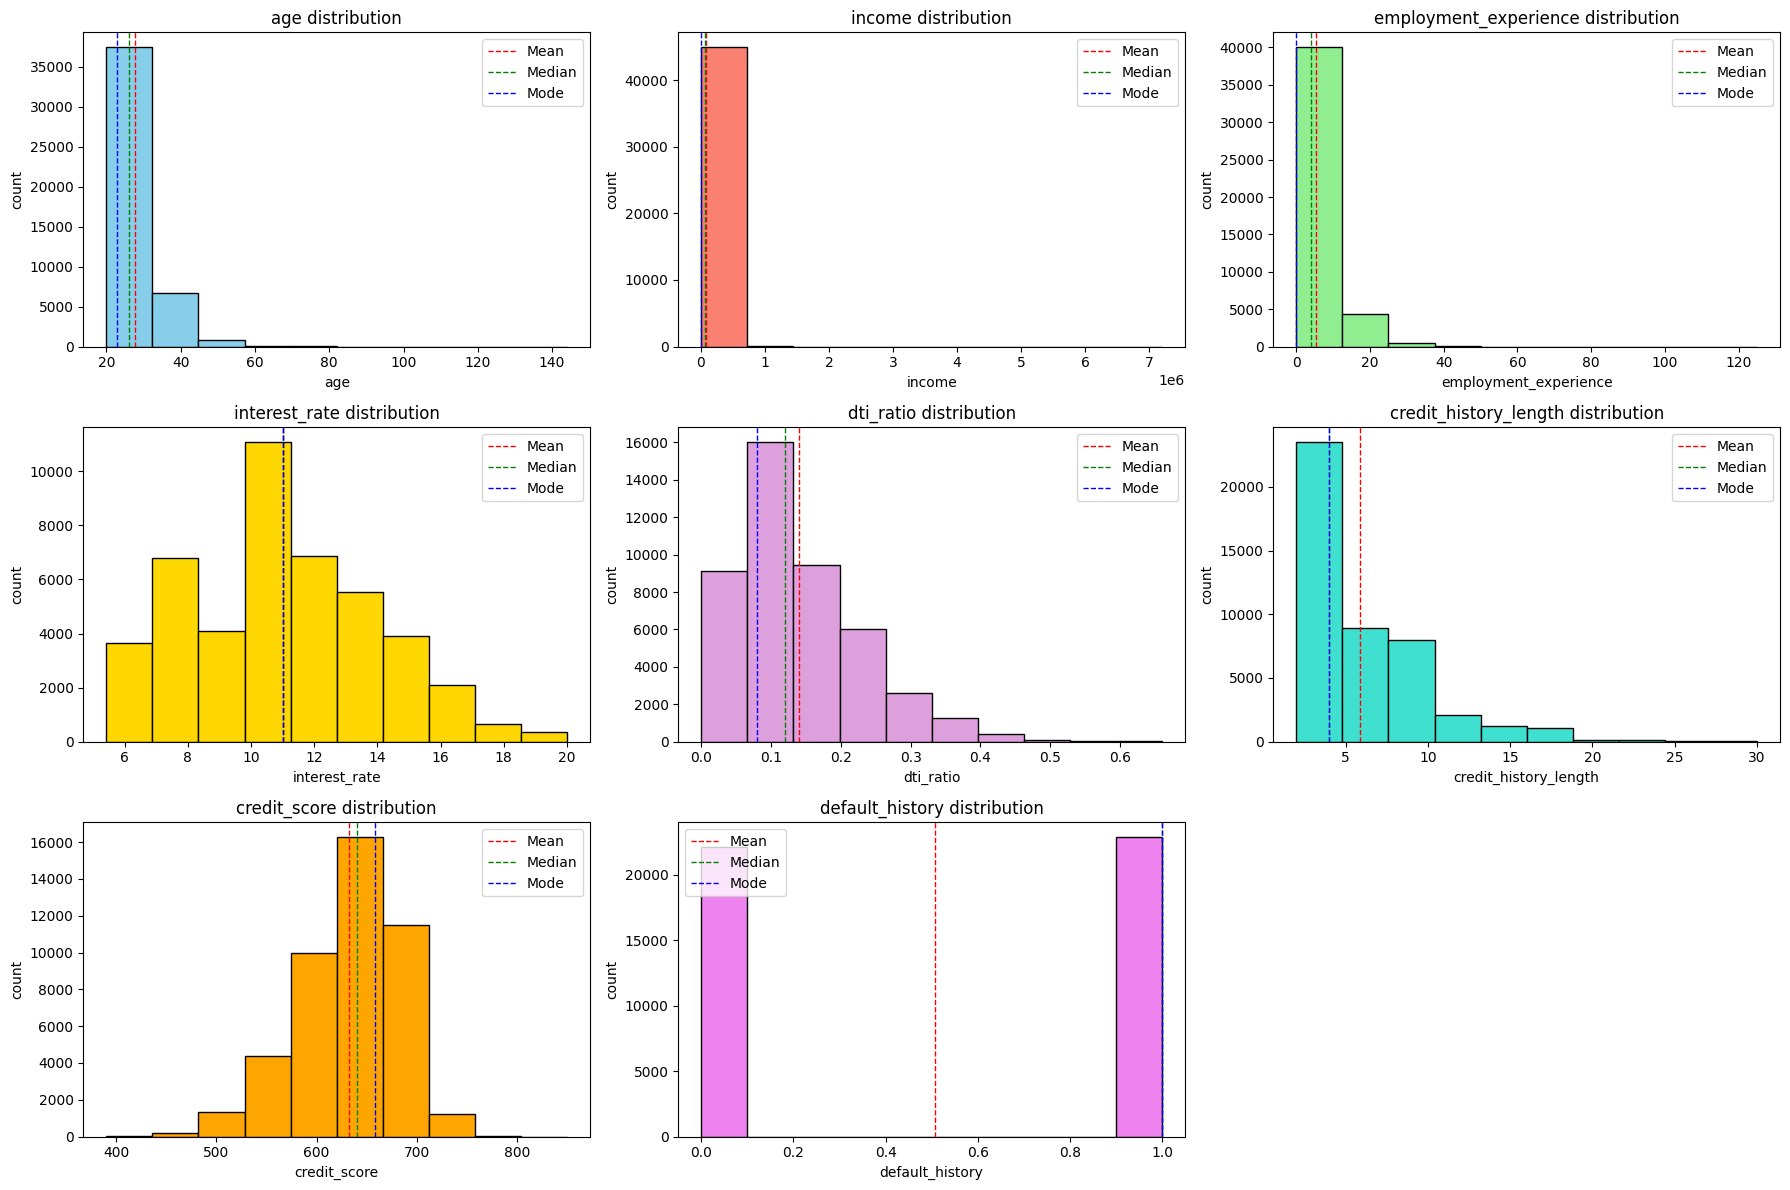

In [17]:
# define the colors
colors = ["skyblue", "salmon", "lightgreen", "gold", "plum", "turquoise", "orange", "violet"]

# Use FEATURE columns
num_feature_cols = [col for col in num_cols if col not in ['loan_outcome', 'loan_amount']]

# Dynamic grid calculation
n_features = len(num_feature_cols)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols

plt.figure(figsize=(18, 4*n_rows))

for i, col in enumerate(num_feature_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    plt.hist(df[col], bins=10, color=colors[i-1], edgecolor="black")
    
    # Add mean and  median sshow also in line
    plt.axvline(df[col].mean(), color='red', linestyle='dashed', linewidth=1, label='Mean')
    plt.axvline(df[col].median(), color='green', linestyle='dashed', linewidth=1, label='Median')
    
    # Safe mode plotting
    modes = df[col].mode()
    if not modes.empty:
        plt.axvline(modes[0], color='blue', linestyle='dashed', linewidth=1, label='Mode')
    
    plt.title(f"{col} distribution")
    plt.xlabel(col)
    plt.ylabel("count")
    plt.legend()

# plot
plt.tight_layout()
plt.show()

1. Age - Most applicants are aged 20–30, with a few older outliers raising the mean. The mode is mid‑20s, showing a youthful applicant pool. This skew may affect risk, as younger borrowers often have shorter credit histories and less financial stability. **Action:** The age groups should be binned, monitor younger applicants’ risk and encode categories for modeling stability.

2. Income - Income is highly skewed, with most applicants earning very little. A few high earners inflate the mean. The mode is near zero. This imbalance suggests inequality **Action:** Apply log transformation, handle outliers, normalize distribution for fairer modeling outcomes.

3. Employment Experience - Most applicants have under 10 years of experience. The mean is higher than the median due to a few long careers. Mode is around 5 years. This reflects early career stages and may correlate with lower income and credit history length. **Action:** Bining experience levels to align with age, simplify categories for clearer model interpretation.

4. Loan Outcome - Loan outcome is binary, mostly 0 (negative). The mean is low, showing class imbalance. **Action:** Apply resampling or class weights, balance target variable and prevent biased predictions.

5. Interest Rate - Interest rates are evenly distributed between 6% and 14%. Mean, median, and mode align, showing no skew. This variable is stable and can be used directly in modeling without transformation. 

6. DTI Ratio - DTI is right‑skewed, with most applicants having low debt relative to income. A few high ratios raise the mean. Mode is near 0.1. High DTI may signal risk **Action:** Cap extreme values, scale ratios, highlight high‑DTI cases for risk monitoring.

7. Credit History Length- - Most applicants have short credit histories of <10 years. The mean is higher than the median due to a few long records. Mode is around 5 years. Short histories may affect creditworthiness and risk assessment. **Action:** Bin into short, medium, long, encode categories, assess impact on loan outcome.

8. Credit Score - Credit scores are symmetric, mostly between 600 and 700. Mean, median, and mode align. This balanced distribution makes credit score a strong, stable predictor for loan outcomes. **Action:** Use directly, consider thresholds and retain raw values as strong predictor.

> Univariate analysis for categorical variables

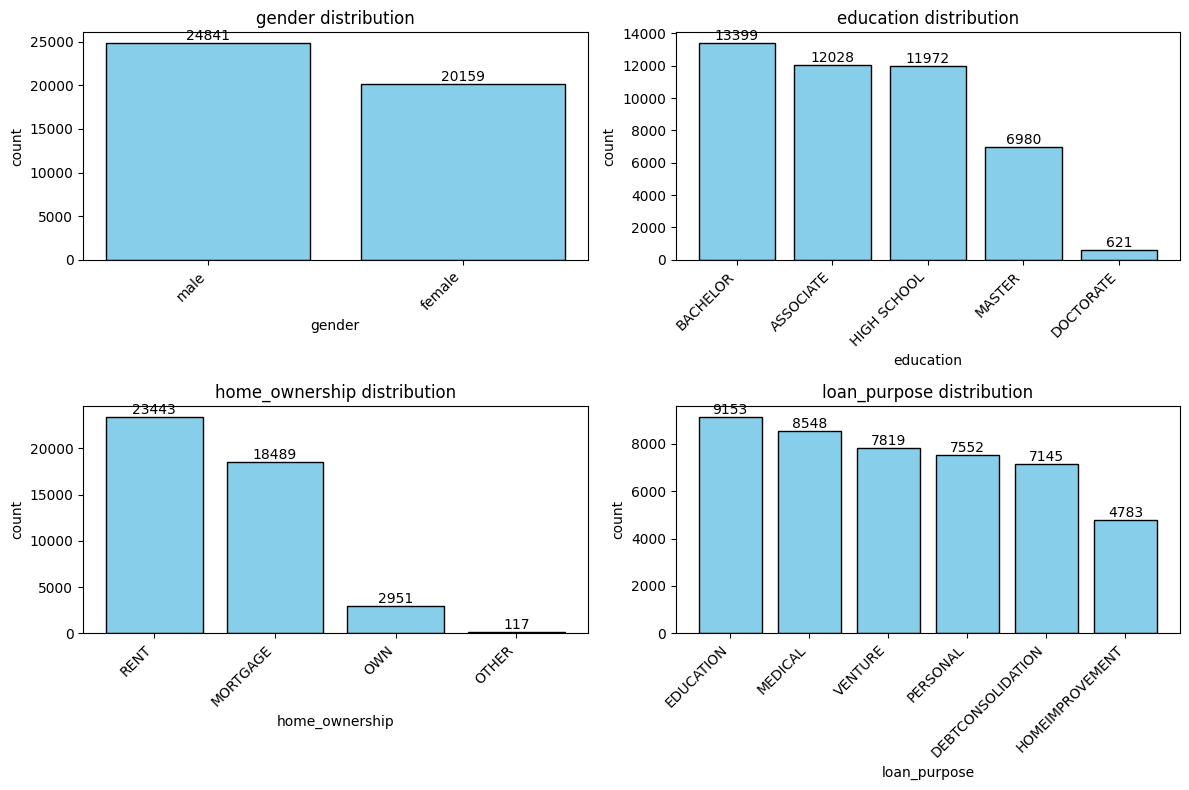

In [18]:
# Dynamic grid
n_cats = len(cat_cols)
n_cols = 2
n_rows = (n_cats + n_cols - 1) // n_cols   

plt.figure(figsize=(12, 4*n_rows))

# Bar plots
for i, col in enumerate(cat_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    
    # Get value counts
    value_counts = df[col].value_counts()
    
    # Plot
    bars = plt.bar(range(len(value_counts)), value_counts.values, 
                   color="skyblue", edgecolor="black")
    
    # Set x-ticks with rotation for long labels
    plt.xticks(range(len(value_counts)), value_counts.index, rotation=45, ha='right')
    
    plt.title(f"{col} distribution")
    plt.xlabel(col)
    plt.ylabel("count")
    
    # Add count labels on top bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

1. Gender - The gender distribution shows whether applicants are balanced across male and female categories. If one group dominates, it may introduce bias in modeling. Since gender is binary, no transformation is needed, but imbalance should be noted. **Action:** Encode as binary, check fairness and monitor bias in predictive modeling.

2. Education - Education levels reveal applicant diversity. If most applicants fall into one category e.g., “Bachelor”, rare categories may need grouping into “Other.” This variable can highlight socioeconomic differences that influence loan outcomes. **Action:** Group rare categories, encode levels and explore correlation with income and loan outcome.

3. Home Ownership - Home ownership status, owner vs renter often reflects financial stability. A dominant category indicates imbalance, while differences across groups may be predictive of default risk. **Action:** Encode ownership tiers, group rare categories and assess impact on default risk.

4. Loan Purpose - Loan purpose typically has multiple categories e.g., personal, business, education. Some purposes may dominate, while others are rare. Rare categories should be grouped to avoid noise. This variable is important for risk segmentation, as purpose often correlates with repayment behavior. **Action:** Group rare purposes, encode categories and analyze default rates by loan purpose.

5. Default History - Default history is binary (yes/no). Most applicants likely have “no default,” but the presence of “yes” cases is critical for modeling. This variable is a strong predictor of loan outcome. **Action:** Encode as binary, prioritize in modeling and highlight default history as key risk feature.

### **3.2.3 Bivariate Analysis**

> Bivariate analysis for Numerical variables vs Target variable

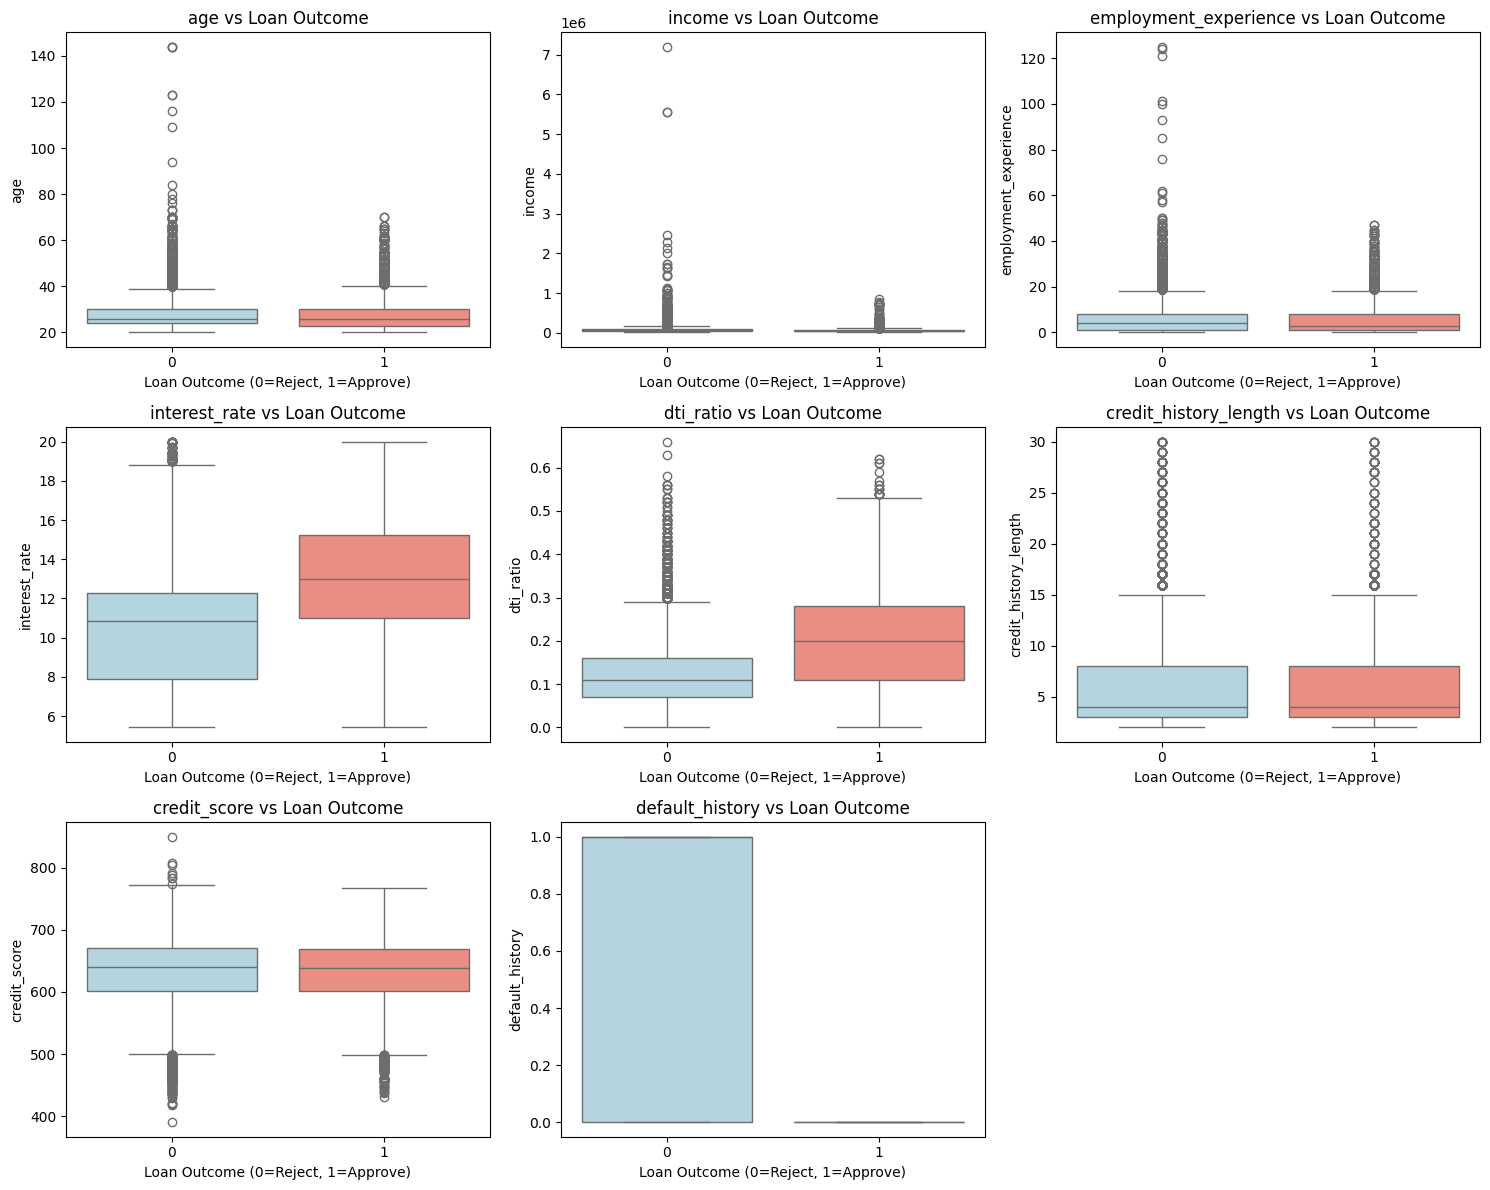

In [19]:
# Dynamic grid
n_features = len(num_feature_cols)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols

plt.figure(figsize=(15, 4*n_rows))

for i, col in enumerate(num_feature_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    
    # Boxplot for binary classification
    sns.boxplot(x="loan_outcome", y=col, data=df, palette=["lightblue", "salmon"])
    
    plt.title(f"{col} vs Loan Outcome", fontsize=12)
    plt.xlabel("Loan Outcome (0=Reject, 1=Approve)", fontsize=10)
    plt.ylabel(col, fontsize=10)
    
    # Add statistical annotation
    rejected = df[df['loan_outcome'] == 0][col]
    approved = df[df['loan_outcome'] == 1][col]

plt.tight_layout()
plt.show()

1. Age - Successful applicants tend to be slightly older, while younger ones show more variability and outliers. Age may weakly influence loan approval. **Action:** binning age groups and dropping if redundant with experience or credit history.

2. Income - Higher income clearly aligns with successful outcomes. Defaults cluster around lower income levels, showing income is a strong predictor of loan performance. **Action:** Apply log transformation, retain as a key feature for modeling.

3. Employment Experience - Applicants with more experience show better outcomes. Defaults are common among those with shorter work histories, reflecting early career risk. **Action:** Bin experience levels, drop if age or credit history already included.

4. Loan Amount - Defaults are more frequent with larger loan amounts. Successful loans tend to be moderate, suggesting risk increases with loan size. **Action:** Apply log scaling, flag large loans and retain for risk modeling.

5. Interest Rate - Successful loans have slightly lower interest rates. Distribution is tight, but shows some separation between outcomes. **Action:** Keep raw, use directly in modeling; consider interaction with credit score.

6. DTI Ratio - Higher DTI ratios are linked to defaults. Successful applicants maintain lower debt relative to income, making DTI a strong risk signal. **Action:** Cap extreme values. scale and retain as a key predictor.

7. Credit History Length - Longer credit histories correlate with successful outcomes. Defaults cluster around shorter histories, showing credit maturity matters. **Action:** Bin into short/medium/long, retain or combine with experience.

8. Credit Score - Higher scores are clearly associated with successful outcomes. Strong separation makes this one of the most powerful predictors. **Action:** Use directly retain as a core feature, consider threshold-based segmentation.

> Bivariate analysis for categorical variables vs Target variable

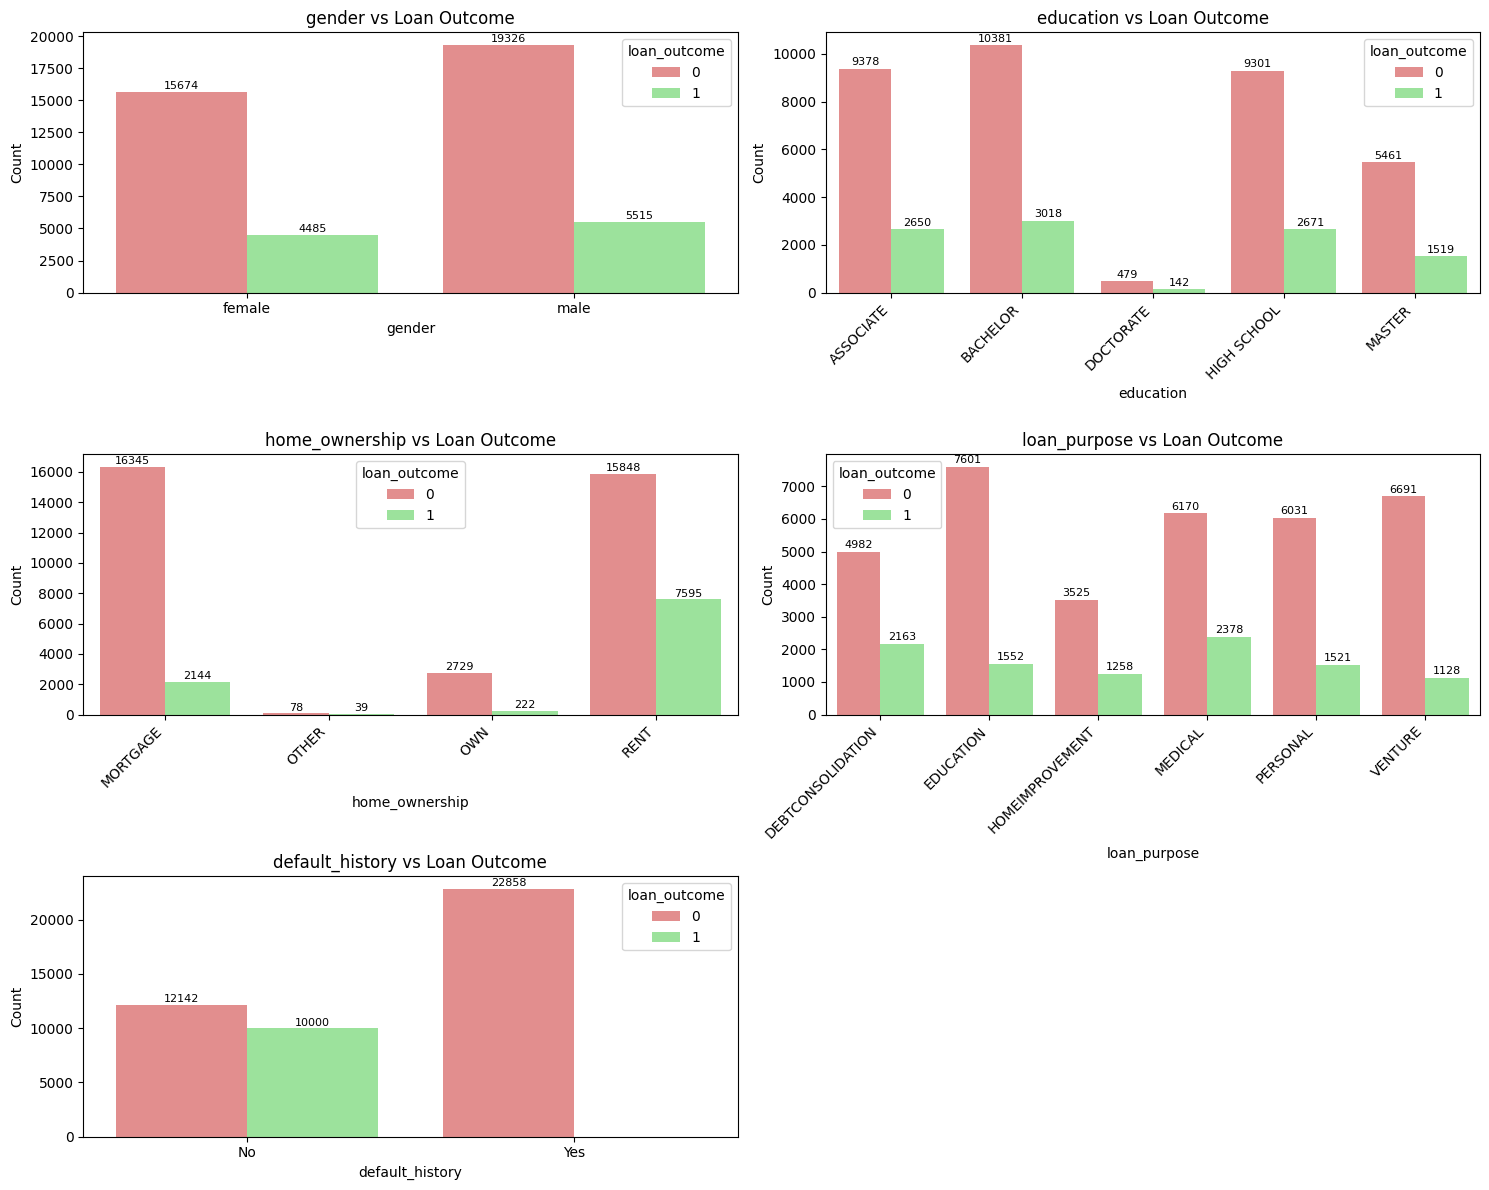

In [20]:
# Include default_history in categorical analysis 
categorical_features = cat_cols + ['default_history']  

# Dynamic grid
n_features = len(categorical_features)
n_cols = 2
n_rows = (n_features + n_cols - 1) // n_cols

plt.figure(figsize=(15, 4*n_rows))

for i, col in enumerate(categorical_features, 1):
    plt.subplot(n_rows, n_cols, i)
    
    # For binary default_history, ensure proper labeling
    if col == 'default_history':
        # Map 1/0 back to Yes/No for visualization
        temp_df = df.copy()
        temp_df['default_history'] = temp_df['default_history'].map({1: 'Yes', 0: 'No'})
        plot_df = temp_df
    else:
        plot_df = df
    
    # Create countplot
    ax = sns.countplot(x=col, hue="loan_outcome", data=plot_df, 
                       palette={0: "lightcoral", 1: "lightgreen"})
    
    plt.title(f"{col} vs Loan Outcome", fontsize=12)
    plt.xlabel(col, fontsize=10)
    plt.ylabel("Count", fontsize=10)
    
    # Smart rotation based on number of categories
    n_categories = len(plot_df[col].unique())
    rotation = 45 if n_categories > 3 else 0
    plt.xticks(rotation=rotation, ha='right' if rotation > 0 else 'center')
    
    # Add percentage annotations
    total_counts = plot_df[col].value_counts()
    for p in ax.patches:
        height = p.get_height()
        if height > 0: 
            ax.text(p.get_x() + p.get_width()/2., height + 50,
                   f'{int(height)}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

In [21]:
# Add chi-square test results
for col in categorical_features:
    contingency_table = pd.crosstab(df[col], df['loan_outcome'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    print(f"{col}: χ²={chi2:.2f}, p={p:.4f}, {'Significant' if p < 0.05 else 'Not significant'}")

gender: χ²=0.01, p=0.9143, Not significant
education: χ²=2.02, p=0.7328, Not significant
home_ownership: χ²=2989.51, p=0.0000, Significant
loan_purpose: χ²=909.65, p=0.0000, Significant
default_history: χ²=13270.29, p=0.0000, Significant


1. Gender - Male applicants dominate both loan outcomes, but the success rate appears similar across genders. No strong predictive separation is visible. **Action:** Encode as binary, retain for fairness checks, drop if model shows no performance gain.

2. Education - Bachelor and High School levels dominate. Higher education such Master, Doctorate shows slightly better outcomes, but sample sizes are small. **Action:** Group rare categories, encode ordinally and explore interaction with income and loan purpose.

3. Home Ownership - Mortgage and Own categories show better outcomes than Rent. Renters have higher default counts, suggesting financial instability. **Action:** Encode ownership tiers, group “Other” and retain as a risk indicator.

4. Loan Purpose - Debt consolidation and personal loans show more defaults. Education loans perform better, suggesting purpose influences repayment behavior. **Action:** Group rare purposes; encode categories and monitor high-risk types like debt and personal loans.

5. Default History - Applicants with prior defaults show significantly more negative outcomes. This is the strongest categorical predictor of loan risk. **Action:** Encode as binary, prioritize in modeling and use for early risk flagging.

### **3.2.4 Multivariate Analysis**

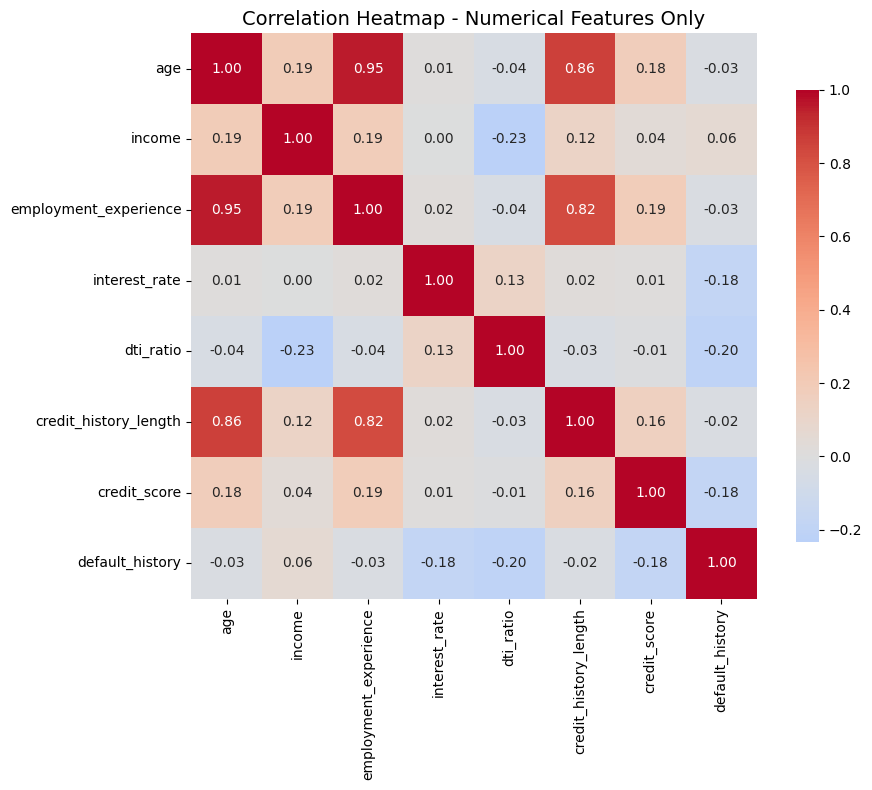

age vs employment_experience: r = 0.954
age vs credit_history_length: r = 0.862
employment_experience vs credit_history_length: r = 0.824


In [22]:
# Use numerical features only (exclude targets)
num_feature_cols = [col for col in df.select_dtypes(include=['int64', 'float64']).columns 
                    if col not in ['loan_outcome', 'loan_amount']]

# Compute correlation
corr_matrix = df[num_feature_cols].corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0, fmt='.2f',
            square=True, cbar_kws={"shrink": 0.8})
plt.title("Correlation Heatmap - Numerical Features Only", fontsize=14)
plt.tight_layout()
plt.show()

# Interpret results
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr_value = abs(corr_matrix.iloc[i, j])
        if corr_value > 0.7:
            col1, col2 = corr_matrix.columns[i], corr_matrix.columns[j]
            high_corr_pairs.append((col1, col2, corr_matrix.iloc[i, j]))
            print(f"{col1} vs {col2}: r = {corr_matrix.iloc[i, j]:.3f}")

In [23]:
# checking n=signifact numerical features
for col in num_feature_cols:
    group0 = df[df['loan_outcome'] == 0][col]
    group1 = df[df['loan_outcome'] == 1][col]
    
    # Remove NaN if any
    group0 = group0.dropna()
    group1 = group1.dropna()
    
    f_stat, p_value = f_oneway(group0, group1)
    print(f"{col}: F={f_stat:.2f}, p={p_value:.4f}, {'Significant' if p_value < 0.05 else 'Not significant'}")

age: F=20.76, p=0.0000, Significant
income: F=845.53, p=0.0000, Significant
employment_experience: F=18.88, p=0.0000, Significant
interest_rate: F=5574.45, p=0.0000, Significant
dti_ratio: F=7824.79, p=0.0000, Significant
credit_history_length: F=9.93, p=0.0016, Significant
credit_score: F=2.63, p=0.1048, Not significant
default_history: F=18824.73, p=0.0000, Significant


In [24]:
# VIF ANALYSIS ro check Multicollinearity
# Prepare data for VIF (add constant)
X_vif = df[num_feature_cols].copy()
X_vif = add_constant(X_vif)

# Calculate VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) 
                   for i in range(len(X_vif.columns))]

print(vif_data.sort_values("VIF", ascending=False))

# Rule of thumb: VIF > 10 indicates severe multicollinearity
high_vif = vif_data[vif_data['VIF'] > 10]
if not high_vif.empty:
    print(f"\nWARNING: {len(high_vif)} features with VIF > 10:")
    print(high_vif[['Feature', 'VIF']])

                 Feature                  VIF
0                  const               374.83
1                    age                14.11
3  employment_experience                11.26
6  credit_history_length                 3.92
5              dti_ratio                 1.11
8        default_history                 1.11
2                 income                 1.11
7           credit_score                 1.07
4          interest_rate                 1.05

                 Feature                  VIF
0                  const               374.83
1                    age                14.11
3  employment_experience                11.26


1. Age, Credit History Length and Employment Experience are highly correlated with severe multicollinearity (VIF > 10). **Action:** Keep Credit History Length (most direct financial indicator, lower VIF=3.92). Drop Age (VIF=14.11) and Employment Experience (VIF=11.26).

2. Gender shows no statistical significance (χ²=0.01, p=0.9143). **Action:** Drop Gender.

3. Education shows no statistical significance (χ²=2.02, p=0.7328). **Action:** Drop Education.

4. Income and Loan Amount are skewed. **Action:** Apply log transformation after train-test split.

5. DTI Ratio is skewed and contains outliers. **Action:** Cap outliers using IQR method, then apply log transformation.

6. Class Imbalance Detected: 77.8% rejected vs 22.2% approved loans. **Action:** Use class_weight='balanced' in classification models.

7. Default History, Home Ownership, Loan Purpose show high statistical significance (p=0.0000). **Action:** Keep all.

8. Credit Score is borderline significant (p=0.1048) but business critical. **Action:** Keep for business logic.

9. DTI Ratio and Interest Rate have highest feature importance. **Action:** Prioritize these features.

> Features to Keep: Credit History Length, Income, DTI Ratio, Interest Rate, Credit Score, Default History, Home Ownership, Loan Purpose and Features to Drop: Age, Employment Experience, Gender, Education

### **3.2.6 Data Preprocessing**

In [25]:
# List of columns to keep for modeling 
selected_cols = [
    "credit_score",
    "credit_history_length", 
    "income",
    "loan_amount",           
    "interest_rate",
    "dti_ratio", 
    "default_history",
    "home_ownership",
    "loan_purpose",
    "loan_outcome"           
]

# Create new DataFrame
data = df[selected_cols].copy()

print("\nTargets:")
print("- loan_outcome (classification)")
print("- loan_amount (regression)")
data.head()


Targets:
- loan_outcome (classification)
- loan_amount (regression)


,credit_score,credit_history_length,income,loan_amount,interest_rate,dti_ratio,default_history,home_ownership,loan_purpose,loan_outcome
0,561,3.00,71948.00,35000.00,16.02,0.49,0,RENT,PERSONAL,1
1,504,2.00,12282.00,1000.00,11.14,0.08,1,OWN,EDUCATION,0
2,635,3.00,12438.00,5500.00,12.87,0.44,0,MORTGAGE,MEDICAL,1
3,675,2.00,79753.00,35000.00,15.23,0.44,0,RENT,MEDICAL,1
4,586,4.00,66135.00,35000.00,14.27,0.53,0,RENT,MEDICAL,1


In [26]:
# Apply basic business rule clipping
business_rules = {
    'income': (0, 10_000_000),      
    'dti_ratio': (0, 1.0),          
    'credit_score': (300, 850),     
    'interest_rate': (0, 30),       
}

for col, (min_val, max_val) in business_rules.items():
    if col in data.columns:
        data[col] = data[col].clip(min_val, max_val)
        print(f"Clipped {col} to [{min_val}, {max_val}]")

Clipped income to [0, 10000000]
Clipped dti_ratio to [0, 1.0]
Clipped credit_score to [300, 850]
Clipped interest_rate to [0, 30]


In [27]:
# Show frequency to identify rare columns
for col in ["home_ownership", "loan_purpose"]:
    print(data[col].value_counts())

home_ownership
RENT        23443
MORTGAGE    18489
OWN          2951
OTHER         117
Name: count, dtype: int64
loan_purpose
EDUCATION            9153
MEDICAL              8548
VENTURE              7819
PERSONAL             7552
DEBTCONSOLIDATION    7145
HOMEIMPROVEMENT      4783
Name: count, dtype: int64


#### Grouping of Rare Categories in categorical variables
1. Home Ownership – Own has 2,951 entries and Other has only 117 entries. Since “Other” is very rare and “Own” is relatively small compared to Rent and Mortgage, combining Own and Other into a single category will be good and will be named as **OWN/OTHER**.

2. Loan Purpose – Education has 9,153, Medical has 8,548, Venture has 7,819, Personal has 7,552, Debt Consolidation has 7,145, and Home Improvement has 4,783 all have several thousand entries. None of these categories are rare enough to warrant grouping, so they will be kept as separate categories for modeling.

In [28]:
# COMBINING RARE CATEGORIES

# HOME OWNERSHIP
data['home_ownership'] = data['home_ownership'].replace({
    'OWN': 'OWN/OTHER',
    'OTHER': 'OWN/OTHER'
})
# preview
print(f'OWN/OTHER contains {(data['home_ownership'] == 'OWN/OTHER').sum()} entries')

OWN/OTHER contains 3068 entries


### **3.2.7 Data Branching**
This project involves building three separate models. To support them, we will create three dataframes from the main dataset, each with the appropriate features and target variable:
1. data_class, for the classification task, where the target variable is loan_outcome. Other target variables will be dropped.
2. data_regres1, for the regression task to predict the loan amount issued.
3. data_regres2, for the clustering to predict the interest rate as part of the risk-based analysis which will be intergrated with central bank Kesonic formula.

In [29]:
### **3.2.6 Data Preprocessing**
data.columns

Index(['credit_score', 'credit_history_length', 'income', 'loan_amount',
       'interest_rate', 'dti_ratio', 'default_history', 'home_ownership',
       'loan_purpose', 'loan_outcome'],
      dtype='object')

In [30]:
# 1. Classification data (loan_outcome as target)
class_features = [
    'credit_score',
    'credit_history_length', 
    'income',
    'dti_ratio',
    'default_history',
    'home_ownership',  
    'loan_purpose',    
    'loan_outcome'     
]

# Check which features actually exist
existing_features = [col for col in class_features if col in data.columns]
data_class = data[existing_features].copy()

# preview
data_class.head()


,credit_score,credit_history_length,income,dti_ratio,default_history,home_ownership,loan_purpose,loan_outcome
0,561,3.00,71948.00,0.49,0,RENT,PERSONAL,1
1,504,2.00,12282.00,0.08,1,OWN/OTHER,EDUCATION,0
2,635,3.00,12438.00,0.44,0,MORTGAGE,MEDICAL,1
3,675,2.00,79753.00,0.44,0,RENT,MEDICAL,1
4,586,4.00,66135.00,0.53,0,RENT,MEDICAL,1


In [31]:
# Data for regression to predict loan amount for APPROVED loans
regression_features = [
    'credit_score',
    'credit_history_length',
    'income',
    'dti_ratio',
    'default_history',
    'home_ownership',       
    'loan_purpose',        
    'loan_amount'          
]

# Check which features actually exist
existing_features = [col for col in regression_features if col in data.columns]

# Create dataset with ALL data first (we'll filter later)
data_regres1 = data[existing_features].copy()

# Now filter to APPROVED LOANS ONLY for regression training
approved_mask = data['loan_outcome'] == 1
data_regres1_approved = data_regres1[approved_mask].copy()

# #  preview
data_regres1_approved.head()

,credit_score,credit_history_length,income,dti_ratio,default_history,home_ownership,loan_purpose,loan_amount
0,561,3.00,71948.00,0.49,0,RENT,PERSONAL,35000.00
2,635,3.00,12438.00,0.44,0,MORTGAGE,MEDICAL,5500.00
3,675,2.00,79753.00,0.44,0,RENT,MEDICAL,35000.00
4,586,4.00,66135.00,0.53,0,RENT,MEDICAL,35000.00
5,532,2.00,12951.00,0.19,0,OWN/OTHER,VENTURE,2500.00


In [32]:
# Data for clustering and interest rate prediction
interest_features = [
    'credit_score',
    'credit_history_length',
    'income',
    'dti_ratio',
    'default_history',
    'loan_amount',        
    'home_ownership',     
    'loan_purpose',       
    'interest_rate'       
]

# Filter to approved loans only
approved_mask = data['loan_outcome'] == 1
data_int = data[approved_mask][interest_features].copy()

# preview
data_int.head()

,credit_score,credit_history_length,income,dti_ratio,default_history,loan_amount,home_ownership,loan_purpose,interest_rate
0,561,3.00,71948.00,0.49,0,35000.00,RENT,PERSONAL,16.02
2,635,3.00,12438.00,0.44,0,5500.00,MORTGAGE,MEDICAL,12.87
3,675,2.00,79753.00,0.44,0,35000.00,RENT,MEDICAL,15.23
4,586,4.00,66135.00,0.53,0,35000.00,RENT,MEDICAL,14.27
5,532,2.00,12951.00,0.19,0,2500.00,OWN/OTHER,VENTURE,7.14


In [33]:
data_int.dtypes

credit_score                int64
credit_history_length     float64
income                    float64
dti_ratio                 float64
default_history             int64
loan_amount               float64
home_ownership           category
loan_purpose             category
interest_rate             float64
dtype: object

## **4.0 Modelling**
The goal of this stage is to build predictive models that address the project objectives. Three analyses will be carried out:
> * Classification - Predict if a loan application should be approved where loan_outcome is the target variable.
> * Regression 1 - Predict the loan amount a client is likely to receive where loan_amount is the target variable.
> * Regression 2 - predict the interest rate at which a given loan will attract and the target variable is intereset_rate.

### **4.1 Classication Model For Approve/Reject**
The classification analysis focuses on predicting whether a client qualifies for a loan. The target variable is loan_outcome, where 1 represents approval and 0 represents rejection.
We will train and evaluate three models and all the models will use a test size of 20% and random state 42, the models include:
> * Logistic Regression
> * Random Forest Classifier
> * XGBoost Classifier

Model performance will be assessed using metrics suited for classification, including accuracy, precision, recall, F1-score, and ROC-AUC. The aim is to select a model that balances predictive accuracy with reliability in identifying eligible applicants.

In [34]:
# efine X and y
y = data_class["loan_outcome"]
X = data_class.drop("loan_outcome", axis=1)

In [35]:
# Encoding categorical columns
X_encoded = pd.get_dummies(X, columns=['home_ownership', 'loan_purpose'], drop_first=True)

print(f"Original X shape: {X.shape}")
print(f"Encoded X shape: {X_encoded.shape}")

Original X shape: (45000, 7)
Encoded X shape: (45000, 12)


In [36]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42, stratify=y)

In [37]:
# Check the shapes
print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

Training data shape: (36000, 12)
Testing data shape: (9000, 12)


In [38]:
# Apply log transformations to skewed features income and dti_ratio
log_transform_cols = ['income', 'dti_ratio']

for col in log_transform_cols:
    if col in X_train.columns:
        # Apply log1p to training data
        X_train[col] = np.log1p(X_train[col])
        
        # Apply same transformation to test data
        X_test[col] = np.log1p(X_test[col])

In [39]:
# Applying IQR clipping to handle extreme values
def clip_iqr_columns(df, columns, iqr_multiplier=1.5):
    """Clip outliers using IQR method"""
    df_clipped = df.copy()
    
    for col in columns:
        if col in df.columns:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            
            lower_bound = Q1 - iqr_multiplier * IQR
            upper_bound = Q3 + iqr_multiplier * IQR
            
            # Count outliers before clipping
            outliers_low = (df[col] < lower_bound).sum()
            outliers_high = (df[col] > upper_bound).sum()
            total_outliers = outliers_low + outliers_high
            
            if total_outliers > 0:
                print(f"  {col}: Clipping {total_outliers} outliers")
                df_clipped[col] = df[col].clip(lower_bound, upper_bound)
    
    return df_clipped

# Apply to numerical columns 
numerical_cols = ['credit_score', 'income', 'dti_ratio', 'credit_history_length']

# Clipping outliers in training data
X_train = clip_iqr_columns(X_train, numerical_cols)

# Applying same clipping bounds to test data
for col in numerical_cols:
    if col in X_train.columns:
        # Use training data bounds for test data
        train_min = X_train[col].min()
        train_max = X_train[col].max()
        X_test[col] = X_test[col].clip(train_min, train_max)

  credit_score: Clipping 406 outliers
  income: Clipping 630 outliers
  dti_ratio: Clipping 407 outliers
  credit_history_length: Clipping 1092 outliers


In [40]:
# Apply StandardScaler to numerical features
scale_cols = ['credit_score', 'income', 'dti_ratio', 'credit_history_length']

# Initialize the scaler
scaler = StandardScaler()

# Fit on TRAIN data only, transform both train and test
X_train[scale_cols] = scaler.fit_transform(X_train[scale_cols])
X_test[scale_cols] = scaler.transform(X_test[scale_cols])

### **4.1.1 Logistic Regression**

In [41]:
# train log_clf
log_clf = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
log_clf.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [42]:
# predict
y_pred_log = log_clf.predict(X_test)

# probability
y_proba_log = log_clf.predict_proba(X_test)[:, 1]

In [43]:
# Hard predictions
y_pred_log = log_clf.predict(X_test)

# Probabilities
y_proba_log = log_clf.predict_proba(X_test)[:, 1]

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_log))

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.79      0.87      7000
           1       0.56      0.91      0.69      2000

    accuracy                           0.82      9000
   macro avg       0.76      0.85      0.78      9000
weighted avg       0.88      0.82      0.83      9000



### **4.1.2 Random Forest Classifier**

In [44]:
# train log_clf
rf_clf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [45]:
# hard predictions
y_pred_rf = rf_clf.predict(X_test)

# probabilites
y_proba_rf = rf_clf.predict_proba(X_test)[:, 1]

In [46]:
# Hard predictions
y_pred_rf = rf_clf.predict(X_test)

# Probabilities
y_proba_rf = rf_clf.predict_proba(X_test)[:, 1]

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_rf))

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94      7000
           1       0.85      0.66      0.74      2000

    accuracy                           0.90      9000
   macro avg       0.88      0.81      0.84      9000
weighted avg       0.90      0.90      0.89      9000



### **Random Forest Classifier Hypeparameter tunning**

In [47]:
# Define the parameter grid
param_dist = {
    'n_estimators': np.arange(100, 500, 50),        
    'max_depth': [None, 5, 10, 20, 30],             
    'min_samples_split': [2, 5, 10],                 
    'min_samples_leaf': [1, 2, 4],                 
    'max_features': ['sqrt', 'log2', None],         
    'class_weight': ['balanced', 'balanced_subsample'] 
}
# Initialize the Random Forest
rf_clf_tuned = RandomForestClassifier(random_state=42)

# Randomized Search
rf_random = RandomizedSearchCV(
    estimator=rf_clf_tuned,
    param_distributions=param_dist,
    n_iter=50,                
    cv=3,                     
    verbose=2,
    random_state=42,
    n_jobs=-1                
)
# Fit the model
rf_random.fit(X_train, y_train)

# Best parameters
print("Best Parameters:", rf_random.best_params_)

# Evaluate on test set
best_rf = rf_random.best_estimator_
y_pred_best_rf = best_rf.predict(X_test)
y_proba_best_rf = best_rf.predict_proba(X_test)[:, 1]

# evaluate metrics
print("Classification Report (Tuned Random Forest):")
print(classification_report(y_test, y_pred_best_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_best_rf))

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'n_estimators': np.int64(400), 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 30, 'class_weight': 'balanced_subsample'}
Classification Report (Tuned Random Forest):
              precision    recall  f1-score   support

           0       0.91      0.97      0.94      7000
           1       0.85      0.67      0.75      2000

    accuracy                           0.90      9000
   macro avg       0.88      0.82      0.84      9000
weighted avg       0.90      0.90      0.89      9000

ROC-AUC: 0.9549735000000001


In [48]:
# Custom threshold evaluation
threshold = 0.35
y_pred_custom = (y_proba_best_rf >= threshold).astype(int)

print("\nClassification Report (Threshold = 0.35):")
print(classification_report(y_test, y_pred_custom))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_best_rf))


Classification Report (Threshold = 0.35):
              precision    recall  f1-score   support

           0       0.94      0.91      0.93      7000
           1       0.72      0.80      0.76      2000

    accuracy                           0.89      9000
   macro avg       0.83      0.86      0.84      9000
weighted avg       0.89      0.89      0.89      9000

ROC-AUC: 0.9549735000000001


### **4.1.3 XGboost Classifier**

In [49]:
# calculate the scale pos weight
scale_pos_weight = len(y_train[y_train==0])/len(y_train[y_train==1])

# Train XGboost
Xgb_clf = XGBClassifier(
    n_estimators = 100,
    learning_rate = 0.1,
    max_depth = 5,
    scale_pos_weight = scale_pos_weight,
    random_state = 42,
    eval_metric = 'logloss'
)
Xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [50]:
# hard predictions
y_pred_xg = Xgb_clf.predict(X_test)

# probabilites
y_proba_xg = Xgb_clf.predict_proba(X_test)[:, 1]

In [51]:
# Hard predictions
y_pred_xg = Xgb_clf.predict(X_test)

# Probabilities
y_proba_xg = Xgb_clf.predict_proba(X_test)[:, 1]

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_xg))

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.83      0.89      7000
           1       0.60      0.92      0.72      2000

    accuracy                           0.85      9000
   macro avg       0.79      0.87      0.81      9000
weighted avg       0.89      0.85      0.85      9000



### **XGBoost Classifier Hypeparameter tunning**

In [52]:
# Calculate scale_pos_weight 
scale_pos_weight = len(y_train[y_train==0]) / len(y_train[y_train==1])

# Define the parameter grid
param_dist = {
    'n_estimators': np.arange(100, 500, 50),       
    'learning_rate': [0.01, 0.05, 0.1, 0.2],       
    'max_depth': [3, 5, 7, 10],                    
    'subsample': [0.6, 0.8, 1.0],                  
    'colsample_bytree': [0.6, 0.8, 1.0],          
    'gamma': [0, 0.1, 0.2, 0.5],                   
    'min_child_weight': [1, 3, 5],                
    'scale_pos_weight': [scale_pos_weight]         
}
# Initialize the XGBClassifier
xgb_clf_tuned = XGBClassifier(
    random_state=42,
    eval_metric='logloss',
    use_label_encoder=False
)
# Randomized Search
xgb_random = RandomizedSearchCV(
    estimator=xgb_clf_tuned,
    param_distributions=param_dist,
    n_iter=50,                
    cv=3,                    
    verbose=2,
    random_state=42,
    n_jobs=-1                 
)
# Fit the model
xgb_random.fit(X_train, y_train)

# Best parameters
print("Best Parameters:", xgb_random.best_params_)

# Evaluate on test set
best_xgb = xgb_random.best_estimator_
y_pred_best_xgb = best_xgb.predict(X_test)
y_proba_best_xgb = best_xgb.predict_proba(X_test)[:, 1]

# esvalute metrics
print("Classification Report (Tuned XGBoost):")
print(classification_report(y_test, y_pred_best_xgb))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_best_xgb))

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'subsample': 0.8, 'scale_pos_weight': 3.5, 'n_estimators': np.int64(400), 'min_child_weight': 1, 'max_depth': 10, 'learning_rate': 0.2, 'gamma': 0.5, 'colsample_bytree': 0.6}
Classification Report (Tuned XGBoost):
              precision    recall  f1-score   support

           0       0.95      0.92      0.93      7000
           1       0.75      0.82      0.78      2000

    accuracy                           0.90      9000
   macro avg       0.85      0.87      0.86      9000
weighted avg       0.90      0.90      0.90      9000

ROC-AUC: 0.9608351428571428


In [53]:
# Custom threshold evaluation
threshold = 0.35
y_pred_custom = (y_proba_best_xgb >= threshold).astype(int)

print("\nClassification Report (Threshold = 0.35):")
print(classification_report(y_test, y_pred_custom))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_best_xgb))


Classification Report (Threshold = 0.35):
              precision    recall  f1-score   support

           0       0.96      0.89      0.92      7000
           1       0.69      0.87      0.77      2000

    accuracy                           0.88      9000
   macro avg       0.83      0.88      0.85      9000
weighted avg       0.90      0.88      0.89      9000

ROC-AUC: 0.9608351428571428


In [54]:
# Save everything needed for production
joblib.dump(best_xgb, "models/final_classifier_xgboost.pkl")
joblib.dump(scaler, "models/classification_scaler.pkl")

['models/classification_scaler.pkl']

In [55]:
import joblib

# Load your trained XGBoost classifier
classifier = joblib.load("models/final_classifier_xgboost.pkl")


In [56]:
print(classifier.get_booster().feature_names)


['credit_score', 'credit_history_length', 'income', 'dti_ratio', 'default_history', 'home_ownership_OWN/OTHER', 'home_ownership_RENT', 'loan_purpose_EDUCATION', 'loan_purpose_HOMEIMPROVEMENT', 'loan_purpose_MEDICAL', 'loan_purpose_PERSONAL', 'loan_purpose_VENTURE']


### **4.2 Regression Model For Loan AMount**

The Regression analysis focuses on determining how much a client qualifies for a loan. The target variable is loan_amount. We will train and evaluate three models and all the models will use a test size of 20% and random state 42, the models include:
> * Linear Regression
> * Random Forest Regressor
> * XGBoost Regressor

### **4.2.1 Linear Regression Model**

In [57]:
# define X and y
y = data_regres1_approved['loan_amount']
X = data_regres1_approved.drop('loan_amount', axis=1)

In [58]:
# Encode categorical columns for regression
# One-hot encode with drop_first
X_encoded = pd.get_dummies(X, columns=['home_ownership', 'loan_purpose'], drop_first=True)

print(f"Original X shape: {X.shape}")
print(f"Encoded X shape: {X_encoded.shape}")

Original X shape: (10000, 7)
Encoded X shape: (10000, 12)


In [59]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

In [60]:
# Log transform features (income, dti_ratio) on BOTH train and test
feature_log_cols = ['income', 'dti_ratio']
for col in feature_log_cols:
    X_train[col] = np.log1p(X_train[col])
    X_test[col] = np.log1p(X_test[col])

# Log transform target (loan_amount) on TRAIN ONLY
y_train_log = np.log1p(y_train)

In [61]:
# Apply IQR clipping 
def clip_iqr_columns(df, columns, iqr_multiplier=1.5):
    """Clip outliers using IQR method"""
    df_clipped = df.copy()
    
    for col in columns:
        if col in df.columns:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            
            lower_bound = Q1 - iqr_multiplier * IQR
            upper_bound = Q3 + iqr_multiplier * IQR
            
            # Count outliers before clipping
            outliers_low = (df[col] < lower_bound).sum()
            outliers_high = (df[col] > upper_bound).sum()
            total_outliers = outliers_low + outliers_high
            
            if total_outliers > 0:
                print(f"  {col}: Clipping {total_outliers} outliers")
                df_clipped[col] = df[col].clip(lower_bound, upper_bound)
    
    return df_clipped

# Apply to numerical columns (after log transform, before scaling)
numerical_cols = ['credit_score', 'income', 'dti_ratio', 'credit_history_length']

In [62]:
# Apply StandardScaler to numerical features
scale_cols = ['credit_score', 'income', 'dti_ratio', 'credit_history_length']

# Initialize the scaler
scaler = StandardScaler()

# Fit on TRAIN data only, transform both train and test
X_train[scale_cols] = scaler.fit_transform(X_train[scale_cols])
X_test[scale_cols] = scaler.transform(X_test[scale_cols])

In [63]:
# check th distribution
print(f"Traning data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

Traning data shape: (8000, 12)
Testing data shape: (2000, 12)


### **4.2.1 Linear Regression Model**

In [64]:
# Intialize and fit
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train_log)

LinearRegression()

In [65]:
# predict on test data
y_pred_lin = lin_reg.predict(X_test)
y_pred_lin

array([10.232134  ,  9.16651054,  8.73086751, ...,  8.40597864,
        7.93336939,  9.72111578], shape=(2000,))

In [66]:
# Convert back to original scale
y_pred_original = np.expm1(y_pred_lin)
y_pred_original

array([27780.73311795,  9570.16814607,  6190.09659866, ...,
        4472.73379666,  2787.80757986, 16664.82973165], shape=(2000,))

In [67]:
#evaluation
rmse = np.sqrt(mean_squared_error(y_test, y_pred_original))
mae = mean_absolute_error(y_test, y_pred_original)
r2 = r2_score(y_test, y_pred_original)

print("\nLinear Regression Results (Original Units):")
print("RMSE:", rmse)
print("MAE:", mae)
print("R²:", r2)



Linear Regression Results (Original Units):
RMSE: 2427.436722701981
MAE: 1473.1205160277432
R²: 0.8873291279247202


### **4.2.2 Random Forest Regression Model**

In [68]:
# intialiaxe and fit
rf_reg = RandomForestRegressor()
rf_reg.fit(X_train, y_train_log)

RandomForestRegressor()

In [69]:
# predict
y_pred_rf = rf_reg.predict(X_test)

In [70]:
# Convert back to original scale
y_pred_original = np.expm1(y_pred_rf)
y_pred_original

array([31439.88198953, 11098.1725009 ,  6070.74198165, ...,
        5000.        ,  3232.56718836, 15225.43634596], shape=(2000,))

In [71]:
#evaluation
rmse = np.sqrt(mean_squared_error(y_test, y_pred_original))
mae = mean_absolute_error(y_test, y_pred_original)
r2 = r2_score(y_test, y_pred_original)

print("\nRandom Forest Regression Results (Original Units):")
print("RMSE:", rmse)
print("MAE:", mae)
print("R²:", r2)



Random Forest Regression Results (Original Units):
RMSE: 444.8649042869949
MAE: 174.08983689860517
R²: 0.9962158171696899


### **Random Forest Regression Hypeparameter tunning**

In [72]:
# Define the parameter grid
param_dist = {
    'n_estimators': np.arange(100, 500, 50),        
    'max_depth': [3, 5, 7, 10],          
    'min_samples_split': [2, 5, 10],                  
    'min_samples_leaf': [1, 2, 4],                    
    'max_features': ['auto', 'sqrt', 'log2'],         
    'bootstrap': [True, False]                        
}

# Initialize the model
rf_reg2 = RandomForestRegressor(random_state=42)

# Randomized Search
random_search = RandomizedSearchCV(
    estimator=rf_reg2,
    param_distributions=param_dist,
    n_iter=50,                
    cv=3,                     
    verbose=2,                
    random_state=42,
    n_jobs=-1                 
)

# Fit on training data
random_search.fit(X_train, y_train_log)

# Best parameters
print("Best Parameters:", random_search.best_params_)

# Best model
best_rf_la = random_search.best_estimator_

# Predict and evaluate
y_pred_rf = best_rf_la.predict(X_test)
y_pred_original = np.expm1(y_pred_rf)

rmse = np.sqrt(mean_squared_error(y_test, y_pred_original))
mae = mean_absolute_error(y_test, y_pred_original)
r2 = r2_score(y_test, y_pred_original)

print("\nTuned Random Forest Results (Original Units):")
print("RMSE:", rmse)
print("MAE:", mae)
print("R²:", r2)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'n_estimators': np.int64(450), 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': False}

Tuned Random Forest Results (Original Units):
RMSE: 2682.4132224380137
MAE: 1441.5938266105604
R²: 0.8624162372539685


### **4.2.3 XGBoost Regression Model**

In [73]:
# intialize and ft
xgb_reg = XGBRegressor()
xgb_reg.fit(X_train, y_train_log)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [74]:
# predict
y_pred_xgb = xgb_reg.predict(X_test)

In [75]:
# Convert back to original scale
y_pred_original = np.expm1(y_pred_xgb)
y_pred_original

array([33925.914 , 10557.048 ,  5516.7085, ...,  4992.103 ,  3101.4917,
       15213.234 ], shape=(2000,), dtype=float32)

In [76]:
# evaluation
rmse = np.sqrt(mean_squared_error(y_test, y_pred_original))
mae = mean_absolute_error(y_test, y_pred_original)
r2 = r2_score(y_test, y_pred_original)

print("\nXGBoost Regression Results (Original Units):")
print("RMSE:", rmse)
print("MAE:", mae)
print("R²:", r2)



XGBoost Regression Results (Original Units):
RMSE: 465.04686563182946
MAE: 229.26095440673828
R²: 0.9958646786506812


### **XGBoost Classifier Hypeparameter tunning**

In [77]:
# Define the parameter grid
param_dist = {
    'n_estimators': np.arange(100, 500, 50),       
    'max_depth': [3, 5, 7, 10],                      
    'learning_rate': [0.01, 0.05, 0.1, 0.2],         
    'subsample': [0.6, 0.8, 1.0],                    
    'colsample_bytree': [0.6, 0.8, 1.0],             
    'gamma': [0, 0.1, 0.2, 0.5],                     
    'reg_alpha': [0, 0.01, 0.1, 1],                  
    'reg_lambda': [1, 1.5, 2]                        
}

# Initialize the model
xgb_reg_tuned = XGBRegressor(random_state=42, objective='reg:squarederror')

# Randomized Search
random_search_xgb = RandomizedSearchCV(
    estimator=xgb_reg_tuned,
    param_distributions=param_dist,
    n_iter=50,                
    cv=3,                     
    verbose=2,                
    random_state=42,
    n_jobs=-1                 
)

# Fit on training data
random_search_xgb.fit(X_train, y_train_log)

# Best parameters
print("Best Parameters:", random_search_xgb.best_params_)

# Best model
best_xgb = random_search_xgb.best_estimator_

# Predict and evaluate
y_pred_xgb = best_xgb.predict(X_test)
y_pred_original = np.expm1(y_pred_xgb)

rmse = np.sqrt(mean_squared_error(y_test, y_pred_original))
mae = mean_absolute_error(y_test, y_pred_original)
r2 = r2_score(y_test, y_pred_original)

print("\nTuned XGBoost Results (Original Units):")
print("RMSE:", rmse)
print("MAE:", mae)
print("R²:", r2)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'subsample': 1.0, 'reg_lambda': 1.5, 'reg_alpha': 0.01, 'n_estimators': np.int64(350), 'max_depth': 7, 'learning_rate': 0.2, 'gamma': 0, 'colsample_bytree': 1.0}

Tuned XGBoost Results (Original Units):
RMSE: 486.2880923752457
MAE: 200.29752578735352
R²: 0.9954782859879304


In [78]:
# Save the best model (Random Forest Baseline)
joblib.dump(rf_reg, "models/best_loan_amount_predictor.pkl")
joblib.dump(scaler, "models/regression_scaler.pkl")

print("✅ Best regression model saved!")

✅ Best regression model saved!


### **4.3 Interest Segmentation For Interest Rate**

This Regression analysis focuses on determining interest rate charged for a given a loan under a risk‑based pricing framework. The target variable is interest rate. We will train and evaluate three models and all the models will use a test size of 20% and random state 42, the models include:
> * Linear Regression
> * Random Forest Regressor
> * XGBoost Regressor


In [79]:
# Encode home_ownership, loan_purpose
data_int_encoded = pd.get_dummies(data_int, columns=['home_ownership', 'loan_purpose'], drop_first=True)

In [80]:
# Defirn X and y
X = data_int_encoded.drop('interest_rate', axis=1)  
y = data_int_encoded['interest_rate']  

In [81]:
# scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

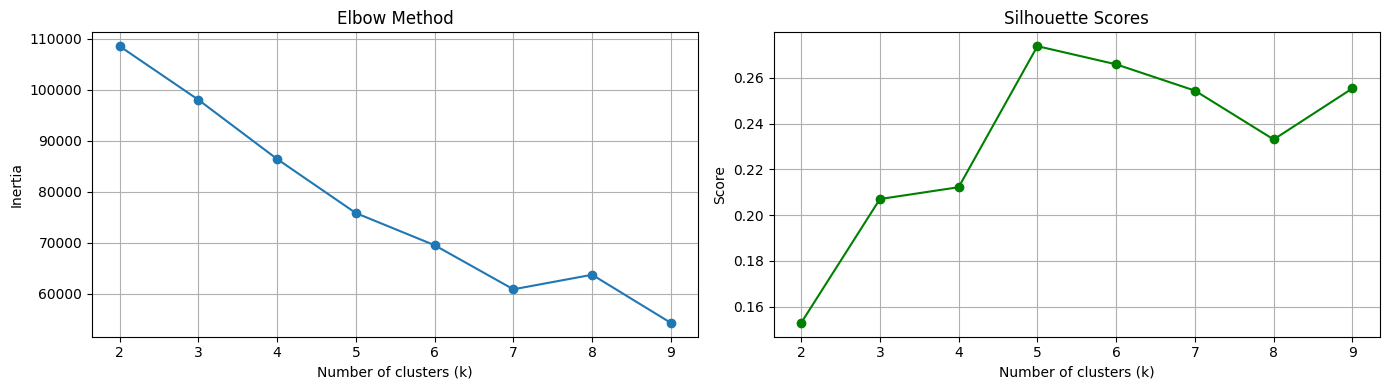

In [82]:
# fin K
inertias = []
sil_scores = []
K_range = range(2, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Plot elbow method
plt.figure(figsize=(14,4))

plt.subplot(1, 2, 1)
plt.plot(K_range, inertias, marker='o')
plt.title("Elbow Method")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.xticks(K_range)
plt.grid(True)

# Plot silhouette scores
plt.subplot(1, 2, 2)
plt.plot(K_range, sil_scores, marker='o', color="green")
plt.title("Silhouette Scores")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Score")
plt.xticks(K_range)
plt.grid(True)

plt.tight_layout()
plt.show()

> The elbow method analysis indicates potential optimal cluster counts at k=4 and k=5,as both represent points of diminishing returns in inertia reduction. To resolve this ambiguity and select the most appropriatenumber of clusters, I conduct further validation using silhouette score analysis. The scores showed that K=5 is better than 4

In [83]:
# view cluster labels
kmeans = KMeans(n_clusters=3, random_state=42, max_iter=1000)
cluster_labels = kmeans.fit_predict(X_scaled)

# preview
cluster_labels[:10]


array([2, 2, 2, 2, 1, 2, 2, 2, 1, 1], dtype=int32)

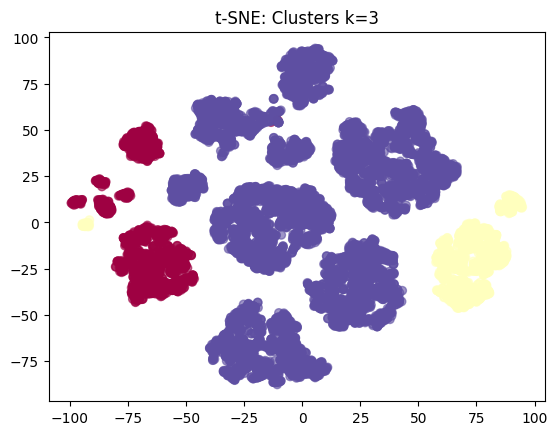

In [84]:
# visualize the cluster using tsne
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_scaled)
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=cluster_labels, cmap='Spectral', alpha=0.6)
plt.title('t-SNE: Clusters k=3')
plt.show()

In [85]:
# Distances in the k-means feature space
centroids = kmeans.cluster_centers_                  
assigned = centroids[cluster_labels]                 
distances = np.linalg.norm(X_scaled - assigned, axis=1)

# Normalize and scale to premium adjustment
premium_adjustment = (distances / distances.max()) * 10

# Attach to the original approved-loans frame
data_int['premium_adjustment'] = premium_adjustment


In [86]:
# Adding the cluster_lables to the data int
data_int['cluster'] = cluster_labels
data_int_encoded["cluster"] = cluster_labels

# preview
data_int.iloc[1010:1015]

,credit_score,credit_history_length,income,dti_ratio,default_history,loan_amount,home_ownership,loan_purpose,interest_rate,premium_adjustment,cluster
2508,706,2.00,22402.00,0.13,0,3000.00,RENT,PERSONAL,11.86,1.95,2
2510,630,2.00,22805.00,0.13,0,3000.00,RENT,MEDICAL,9.70,1.50,2
2512,495,4.00,23480.00,0.13,0,3000.00,RENT,HOMEIMPROVEMENT,10.99,1.89,0
2514,670,2.00,23799.00,0.13,0,3000.00,RENT,VENTURE,13.06,1.17,1
2515,530,2.00,24037.00,0.12,0,3000.00,RENT,VENTURE,12.99,1.62,1


In [87]:
# Analyze the real risk factors for each cluster
cluster_stats = data_int.groupby('cluster').agg({
    'credit_score': 'mean',
    'interest_rate': 'mean',
    'default_history': 'mean',
    'dti_ratio': 'mean',
    'income': 'mean'
}).round(2)

# Sort by risk 
cluster_stats['risk_score'] = (
    (cluster_stats['credit_score'].max() - cluster_stats['credit_score']) +  
    (cluster_stats['interest_rate'] - cluster_stats['interest_rate'].min())   
)

cluster_stats['risk_rank'] = cluster_stats['risk_score'].rank()
cluster_stats[['credit_score', 'interest_rate', 'default_history', 'risk_score', 'risk_rank']].sort_values('risk_rank')

,credit_score,interest_rate,default_history,risk_score,risk_rank
cluster,,,,,
1,633.50,12.89,0.00,0.12,1.00
2,632.03,12.87,0.00,1.57,2.00
0,629.89,12.77,0.00,3.61,3.00


In [88]:
# Rename the clusters 
cluster_names = {
    1: "Prime",
    2: "Preferred",
    0: "Standard"
}

data_int['cluster_name'] = data_int['cluster'].map(cluster_names)
data_int[['cluster','cluster_name']].head()

,cluster,cluster_name
0,2,Preferred
2,2,Preferred
3,2,Preferred
4,2,Preferred
5,1,Prime


In [89]:
# Assign Base Premiums per Risk Band
premium_mapping = {
    "Prime": 0.3,
    "Preferred": 0.6,
    "Standard": 1.0
}

data_int['base_premium'] = data_int['cluster_name'].map(premium_mapping)
data_int[['cluster_name','base_premium']].head()

,cluster_name,base_premium
0,Preferred,0.60
2,Preferred,0.60
3,Preferred,0.60
4,Preferred,0.60
5,Prime,0.30


In [90]:
# create the final rate
margin = 0.5  
data_int['final_rate'] = data_int['base_premium'] + data_int['premium_adjustment'] + margin

# Preview
data_int[['cluster_name','base_premium','premium_adjustment','final_rate']].head()


,cluster_name,base_premium,premium_adjustment,final_rate
0,Preferred,0.60,2.99,4.09
2,Preferred,0.60,2.12,3.22
3,Preferred,0.60,2.66,3.76
4,Preferred,0.60,2.88,3.98
5,Prime,0.30,3.96,4.76


In [91]:
# final kesonia fomula

data_int['kesonic_rate_pct'] = 10.09 + data_int['final_rate']

print("Final Kesonic Rates (in %):")
data_int[['cluster_name', 'base_premium', 'premium_adjustment', 'final_rate', 'kesonic_rate_pct', 'interest_rate']].head(10)

Final Kesonic Rates (in %):


,cluster_name,base_premium,premium_adjustment,final_rate,kesonic_rate_pct,interest_rate
0,Preferred,0.60,2.99,4.09,14.18,16.02
2,Preferred,0.60,2.12,3.22,13.31,12.87
3,Preferred,0.60,2.66,3.76,13.85,15.23
4,Preferred,0.60,2.88,3.98,14.07,14.27
5,Prime,0.30,3.96,4.76,14.85,7.14
6,Preferred,0.60,2.72,3.82,13.91,12.42
7,Preferred,0.60,2.49,3.59,13.68,11.11
8,Preferred,0.60,2.81,3.91,14.00,8.90
9,Prime,0.30,3.82,4.62,14.71,14.74
10,Prime,0.30,2.12,2.92,13.01,10.37


In [92]:

# 1. Save K-means model
joblib.dump(kmeans, 'models/kmeans_model.pkl')

# 2. Save scaler  
joblib.dump(scaler, 'models/kesonic_scaler.pkl')

# 3. Save max distance for premium calculation
np.save('models/max_distance.npy', distances.max())

# 4. Save cluster names and premium mapping
cluster_info = {
    'cluster_names': cluster_names,
    'premium_mapping': premium_mapping,
    'feature_names': list(X.columns),
    'max_distance': distances.max(),
    'kesonia_base': 10.09,  
    'margin': 0.5
}

with open('models/cluster_info.pkl', 'wb') as f:
    pickle.dump(cluster_info, f)

In [93]:
# Test the models and flow
# Load  models
final_classifier = joblib.load("models/final_classifier_xgboost.pkl")
classification_scaler = joblib.load("models/classification_scaler.pkl")
regression_model = joblib.load("models/best_loan_amount_predictor.pkl")
regression_scaler = joblib.load("models/regression_scaler.pkl")
kesonic_kmeans = joblib.load("models/kmeans_model.pkl")
kesonic_scaler = joblib.load("models/kesonic_scaler.pkl")

# Load KESONIC cluster info
with open('models/cluster_info.pkl', 'rb') as f:
    cluster_info = pickle.load(f)

cluster_names = cluster_info['cluster_names'] 
premium_mapping = cluster_info['premium_mapping']  
max_distance = cluster_info['max_distance']
kesonic_features = cluster_info['feature_names']
KESONIA_TODAY = cluster_info['kesonia_base']  
margin = cluster_info['margin']  


# ceat the kesonia rate
def calculate_kesonic_rate(borrower_data, loan_amount):
    kesonic_data = borrower_data.copy()
    
    # Add required features for clustering
    kesonic_data['loan_amount'] = loan_amount
    kesonic_data['employment_length'] = 5  # Default assumption
    
    # Convert to DataFrame
    kesonic_df = pd.DataFrame([kesonic_data])
    
    # Encode categoricals EXACTLY like clustering training
    kesonic_encoded = pd.get_dummies(kesonic_df, 
                                    columns=['home_ownership', 'loan_purpose'], 
                                    drop_first=True)
    
    # Ensure all KESONIA features are present
    for col in kesonic_features:
        if col not in kesonic_encoded.columns:
            kesonic_encoded[col] = 0
    
    # Reorder to match training
    kesonic_encoded = kesonic_encoded[kesonic_features]
    
    # Scale using KESONIA scaler
    kesonic_scaled = kesonic_scaler.transform(kesonic_encoded)
    
    # Predict cluster
    cluster = kesonic_kmeans.predict(kesonic_scaled)[0]
    cluster_name = cluster_names.get(cluster, "Standard")
    
    # Calculate distance for premium adjustment
    centroid = kesonic_kmeans.cluster_centers_[cluster]
    distance = np.linalg.norm(kesonic_scaled - centroid)
    premium_adjustment = (distance / max_distance) * 10  # 0-10% range
    
    # Apply Kesonic formula
    base_premium = premium_mapping.get(cluster_name, 1.0)
    final_rate = base_premium + premium_adjustment + margin
    
    # Calculate final interest rate
    interest_rate = KESONIA_TODAY + final_rate
    
    return {
        'cluster': cluster,
        'cluster_name': cluster_name,
        'premium_adjustment': premium_adjustment,
        'base_premium': base_premium,
        'margin': margin,
        'final_rate': final_rate,
        'kesonia_base': KESONIA_TODAY,
        'interest_rate': interest_rate
    }

# ====================
# 3. TEST SINGLE BORROWER (ALL 3 STAGES)
# ====================
print("\n" + "="*60)
print("SINGLE BORROWER TEST - ALL 3 STAGES")
print("="*60)

# Create test borrower
test_borrower = pd.DataFrame([{
    'credit_score': 720,
    'credit_history_length': 5,
    'income': 85000,
    'dti_ratio': 0.35,
    'default_history': 0,
    'home_ownership': 'RENT',
    'loan_purpose': 'PERSONAL'
}])

print("\nTest Borrower:")
print(test_borrower)

# We need to preprocess EXACTLY like training
# 1. Encode categoricals
test_encoded = pd.get_dummies(test_borrower, 
                             columns=['home_ownership', 'loan_purpose'], 
                             drop_first=True)

# 2. Ensure all columns match training
# Get training columns from saved configuration or X_train
training_columns = X_train.columns.tolist()

# Add missing columns with 0
missing_cols = set(training_columns) - set(test_encoded.columns)
for col in missing_cols:
    test_encoded[col] = 0

# Reorder to match training
test_encoded = test_encoded[training_columns]

print(f"\nAfter encoding - shape: {test_encoded.shape}")

# 3. Apply log transform (same as training)
log_cols = ['income', 'dti_ratio']
for col in log_cols:
    if col in test_encoded.columns:
        test_encoded[col] = np.log1p(test_encoded[col])

# 4. Scale (using saved scaler)
scale_cols = ['credit_score', 'income', 'dti_ratio', 'credit_history_length']

# For classification prediction
test_encoded_clf = test_encoded.copy()
test_encoded_clf[scale_cols] = classification_scaler.transform(test_encoded[scale_cols])

# For regression prediction (if approved)
test_encoded_reg = test_encoded.copy()
test_encoded_reg[scale_cols] = regression_scaler.transform(test_encoded[scale_cols])

# Stage 1: Classification
approval_prob = final_classifier.predict_proba(test_encoded_clf)[:, 1][0]
approval_decision = approval_prob >= 0.35

print(f"\n📊 STAGE 1: LOAN APPROVAL")
print(f"  Approval Probability: {approval_prob:.2%}")
print(f"  Status: {'✅ APPROVED' if approval_decision else '❌ REJECTED'}")

if approval_decision:
    # Stage 2: Loan Amount
    loan_amount_log = regression_model.predict(test_encoded_reg)[0]
    loan_amount = np.expm1(loan_amount_log)
    print(f"\n💰 STAGE 2: LOAN AMOUNT")
    print(f"  Eligible loan amount: ${loan_amount:,.2f}")
    
    # Stage 3: Interest Rate
    print(f"\n📈 STAGE 3: INTEREST RATE (KESONIC)")
    
    # Prepare borrower data for KESONIC
    borrower_raw_data = {
        'credit_score': 720,
        'credit_history_length': 5,
        'income': 85000,
        'dti_ratio': 0.35,
        'default_history': 0,
        'home_ownership': 'RENT',
        'loan_purpose': 'PERSONAL'
    }
    
    kesonic_result = calculate_kesonic_rate(borrower_raw_data, loan_amount)
    
    print(f"  Risk Cluster: {kesonic_result['cluster_name']} (Cluster {kesonic_result['cluster']})")
    print(f"  Premium Adjustment: {kesonic_result['premium_adjustment']:.2f}%")
    print(f"  Base Premium: {kesonic_result['base_premium']:.2f}%")
    print(f"  Operating Margin: {kesonic_result['margin']:.2f}%")
    print(f"  Total Premium (K): {kesonic_result['final_rate']:.2f}%")
    print(f"  KESONIA Base Rate: {kesonic_result['kesonia_base']:.2f}%")
    print(f"  🔥 FINAL INTEREST RATE: {kesonic_result['interest_rate']:.2f}%")
    
else:
    print(f"\n💸 No loan amount (application rejected)")

# ====================
# 4. TEST MULTIPLE BORROWERS (ALL 3 STAGES)
# ====================
print("\n" + "="*60)
print("TESTING 23 BORROWERS: COMPLETE 3-STAGE PROCESS")
print("="*60)

test_cases = [
    {"credit_score": 780, "income": 120000, "dti_ratio": 0.25, "default_history": 0},
    {"credit_score": 620, "income": 45000, "dti_ratio": 0.55, "default_history": 1},
    {"credit_score": 700, "income": 67000, "dti_ratio": 0.40, "default_history": 0},
    {"credit_score": 780, "income": 12000, "dti_ratio": 0.25, "default_history": 0},
    {"credit_score": 720, "income": 100000, "dti_ratio": 0.30, "default_history": 0},
    {"credit_score": 760, "income": 110000, "dti_ratio": 0.28, "default_history": 1},
    {"credit_score": 740, "income": 88000, "dti_ratio": 0.32, "default_history": 0},
    {"credit_score": 710, "income": 82000, "dti_ratio": 0.35, "default_history": 0},
    {"credit_score": 680, "income": 15000, "dti_ratio": 0.38, "default_history": 0},
    {"credit_score": 650, "income": 68000, "dti_ratio": 0.40, "default_history": 1},
    {"credit_score": 700, "income": 90000, "dti_ratio": 0.42, "default_history": 0},
    {"credit_score": 630, "income": 72000, "dti_ratio": 0.36, "default_history": 0},
    {"credit_score": 690, "income": 78000, "dti_ratio": 0.45, "default_history": 0},
    {"credit_score": 620, "income": 45000, "dti_ratio": 0.55, "default_history": 1},
    {"credit_score": 600, "income": 52000, "dti_ratio": 0.48, "default_history": 0},
    {"credit_score": 580, "income": 24000, "dti_ratio": 0.50, "default_history": 0},
    {"credit_score": 640, "income": 50000, "dti_ratio": 0.52, "default_history": 0},
    {"credit_score": 550, "income": 42000, "dti_ratio": 0.47, "default_history": 1},
    {"credit_score": 800, "income": 150000, "dti_ratio": 0.60, "default_history": 0},
    {"credit_score": 500, "income": 35000, "dti_ratio": 0.30, "default_history": 0},
    {"credit_score": 750, "income": 200000, "dti_ratio": 0.18, "default_history": 1},
    {"credit_score": 670, "income": 85000, "dti_ratio": 0.65, "default_history": 0},
    {"credit_score": 590, "income": 55000, "dti_ratio": 0.38, "default_history": 0},
    {"credit_score": 850, "income": 300000, "dti_ratio": 0.10, "default_history": 0},  # SUPER PRIME
    {"credit_score": 350, "income": 15000, "dti_ratio": 0.80, "default_history": 1},   # VERY RISKY
    {"credit_score": 820, "income": 250000, "dti_ratio": 0.12, "default_history": 0},  # PRIME
    {"credit_score": 420, "income": 18000, "dti_ratio": 0.75, "default_history": 0}   # STANDARD
]

results = []

for i, borrower in enumerate(test_cases, 1):
    print(f"\nBorrower {i}:")
    print(f"  Credit: {borrower['credit_score']}, Income: ${borrower['income']:,}, DTI: {borrower['dti_ratio']}")
    print(f"  Default History: {'Yes' if borrower['default_history'] else 'No'}")
    
    # Prepare borrower dict
    borrower_data = {
        'credit_score': borrower['credit_score'],
        'credit_history_length': 5,
        'income': borrower['income'],
        'dti_ratio': borrower['dti_ratio'],
        'default_history': borrower['default_history'],
        'home_ownership': 'RENT',
        'loan_purpose': 'PERSONAL'
    }
    
    # Convert to DataFrame
    borrower_df = pd.DataFrame([borrower_data])
    
    # Preprocess for Stage 1 & 2
    borrower_encoded = pd.get_dummies(borrower_df, columns=['home_ownership', 'loan_purpose'], drop_first=True)
    
    # Add missing columns
    missing = set(training_columns) - set(borrower_encoded.columns)
    for col in missing:
        borrower_encoded[col] = 0
    borrower_encoded = borrower_encoded[training_columns]
    
    # Transform
    for col in log_cols:
        if col in borrower_encoded.columns:
            borrower_encoded[col] = np.log1p(borrower_encoded[col])
    
    # For classification
    borrower_encoded_clf = borrower_encoded.copy()
    borrower_encoded_clf[scale_cols] = classification_scaler.transform(borrower_encoded[scale_cols])
    
    # For regression
    borrower_encoded_reg = borrower_encoded.copy()
    borrower_encoded_reg[scale_cols] = regression_scaler.transform(borrower_encoded[scale_cols])
    
    # Stage 1: Classification
    prob = final_classifier.predict_proba(borrower_encoded_clf)[:, 1][0]
    approved = prob >= 0.35
    
    print(f"  Stage 1 - Approval: {prob:.2%} -> {'✅ APPROVED' if approved else '❌ REJECTED'}")
    
    if approved:
        # Stage 2: Loan Amount
        loan_amount_log = regression_model.predict(borrower_encoded_reg)[0]
        loan_amount = np.expm1(loan_amount_log)
        print(f"  Stage 2 - Loan Amount: ${loan_amount:,.2f}")
        
        # Stage 3: Interest Rate
        kesonic_result = calculate_kesonic_rate(borrower_data, loan_amount)
        print(f"  Stage 3 - Interest Rate: {kesonic_result['interest_rate']:.2f}%")
        print(f"    Cluster: {kesonic_result['cluster_name']}, Premium Adj: {kesonic_result['premium_adjustment']:.2f}%")
        
        # Store results
        results.append({
            'borrower': i,
            'credit_score': borrower['credit_score'],
            'income': borrower['income'],
            'dti_ratio': borrower['dti_ratio'],
            'default': borrower['default_history'],
            'approved': True,
            'loan_amount': loan_amount,
            'interest_rate': kesonic_result['interest_rate'],
            'cluster': kesonic_result['cluster_name'],
            'premium_adjustment': kesonic_result['premium_adjustment']
        })
    else:
        print(f"  Stage 2 & 3: Not applicable (rejected)")
        results.append({
            'borrower': i,
            'credit_score': borrower['credit_score'],
            'income': borrower['income'],
            'dti_ratio': borrower['dti_ratio'],
            'default': borrower['default_history'],
            'approved': False,
            'loan_amount': 0,
            'interest_rate': 0,
            'cluster': 'N/A',
            'premium_adjustment': 0
        })
    
    if i % 5 == 0:
        print("-" * 60)

# ====================
# 5. SUMMARY
# ====================
print("\n" + "="*60)
print("SUMMARY OF RESULTS (3-STAGE PIPELINE)")
print("="*60)

approved_loans = [r for r in results if r['approved']]
rejected_loans = [r for r in results if not r['approved']]

print(f"\n📊 APPROVED LOANS: {len(approved_loans)}/{len(results)}")
if approved_loans:
    avg_loan = np.mean([r['loan_amount'] for r in approved_loans])
    avg_rate = np.mean([r['interest_rate'] for r in approved_loans])
    print(f"  Average Loan Amount: ${avg_loan:,.2f}")
    print(f"  Average Interest Rate: {avg_rate:.2f}%")
    
    print(f"\n📈 INTEREST RATE DISTRIBUTION BY CLUSTER:")
    # Only 3 clusters now: Prime, Preferred, Standard
    for cluster_name in ['Prime', 'Preferred', 'Standard']:
        cluster_rates = [r['interest_rate'] for r in approved_loans if r['cluster'] == cluster_name]
        if cluster_rates:
            print(f"  {cluster_name}: {len(cluster_rates)} loans, Avg rate: {np.mean(cluster_rates):.2f}%")

print(f"\n❌ REJECTED LOANS: {len(rejected_loans)}")
if rejected_loans:
    avg_credit_rejected = np.mean([r['credit_score'] for r in rejected_loans])
    print(f"  Average Credit Score of rejected: {avg_credit_rejected:.0f}")

print("\n" + "="*60)
print("🎉 TESTING COMPLETE - 3-STAGE PIPELINE WORKING!")
print("="*60)


SINGLE BORROWER TEST - ALL 3 STAGES

Test Borrower:
   credit_score  credit_history_length  income            dti_ratio  \
0           720                      5   85000                 0.35   

   default_history home_ownership loan_purpose  
0                0           RENT     PERSONAL  

After encoding - shape: (1, 12)

📊 STAGE 1: LOAN APPROVAL
  Approval Probability: 28.79%
  Status: ❌ REJECTED

💸 No loan amount (application rejected)

TESTING 23 BORROWERS: COMPLETE 3-STAGE PROCESS

Borrower 1:
  Credit: 780, Income: $120,000, DTI: 0.25
  Default History: No
  Stage 1 - Approval: 54.40% -> ✅ APPROVED
  Stage 2 - Loan Amount: $31,251.07
  Stage 3 - Interest Rate: 13.93%
    Cluster: Preferred, Premium Adj: 2.74%

Borrower 2:
  Credit: 620, Income: $45,000, DTI: 0.55
  Default History: Yes
  Stage 1 - Approval: 0.00% -> ❌ REJECTED
  Stage 2 & 3: Not applicable (rejected)

Borrower 3:
  Credit: 700, Income: $67,000, DTI: 0.4
  Default History: No
  Stage 1 - Approval: 54.08% -> ✅ A

In [94]:
print(classifier.get_booster().feature_names)


['credit_score', 'credit_history_length', 'income', 'dti_ratio', 'default_history', 'home_ownership_OWN/OTHER', 'home_ownership_RENT', 'loan_purpose_EDUCATION', 'loan_purpose_HOMEIMPROVEMENT', 'loan_purpose_MEDICAL', 'loan_purpose_PERSONAL', 'loan_purpose_VENTURE']
